# Predição de dose semanal para regulação de INR no uso da Vafarina

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import joblib
import xgboost as xgb
import lightgbm as lgb
import optuna
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from models.data_manipulator import INRDataManipulation
import warnings
warnings.filterwarnings("ignore")

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Importação e tratamento dos dados

In [2]:
path1 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ADRIANA RAMOS PESSOA.xlsx"
path2 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALCIDES DE CARVALHO GALVAO.xlsx"
path3 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALEXANDRE JOSE MARTINS BORBOREMA2.xlsx"
path4 = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALINE GOMES DE FREITAS RICARDO.xlsx"

In [3]:
data1 = pd.read_excel(path1, sheet_name="TTR")
data2 = pd.read_excel(path2, sheet_name="TTR")
data3 = pd.read_excel(path3, sheet_name="TTR")
data4 = pd.read_excel(path4, sheet_name="TTR")
display(data1.head())
display(data2.head())
display(data3.head())
display(data4.head())

,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,0.0,2022-10-10,1.21,NaN,,NaN,Below,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.000000
1,20.0,2022-10-18,1.43,8.0,0.22,Below,Below,Below,0.0,0.0,0.22,0.0,0.0,NaN,High Range,3.000000
2,22.5,2022-10-25,1.58,7.0,0.15,Below,Below,Below,0.0,0.0,0.15,0.0,0.0,NaN,NaN,NaN
3,25.0,2022-11-01,1.50,7.0,-0.08,Below,Below,Below,0.0,0.0,0.08,0.0,0.0,NaN,Rosendaal Method,NaN
4,27.5,2022-11-22,1.75,21.0,0.25,Below,Below,Below,0.0,0.0,0.25,0.0,0.0,NaN,Days Within Range,118668.038839


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,35 MG,2025-03-18,4.84,NaN,,NaN,Above,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.500000
1,32.5,2025-03-25,2.35,7.0,-2.49,Above,Below,Calculate,1.34,1.00,0.15,2.811245,0.401606,NaN,High Range,3.500000
2,32.5,2025-04-08,3.93,14.0,1.58,Below,Above,Calculate,0.43,1.00,0.15,8.860759,0.632911,NaN,NaN,NaN
3,30,2025-04-15,3.03,7.0,-0.9,Above,In Range,Calculate,0.43,0.47,0.00,3.655556,0.522222,NaN,Rosendaal Method,NaN
4,30,2025-04-29,2.48,14.0,-0.55,In Range,Below,Calculate,0.00,0.53,0.02,13.490909,0.963636,NaN,Days Within Range,30.173308


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,90.0,2022-07-27,2.94,NaN,,NaN,In Range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.500000
1,97.5,2022-08-02,2.84,6.0,-0.1,In Range,In Range,In Range,0.0,0.10,0.0,6.0,1.0,NaN,High Range,3.500000
2,97.5,2022-08-16,2.93,14.0,0.09,In Range,In Range,In Range,0.0,0.09,0.0,14.0,1.0,NaN,NaN,NaN
3,97.5,2022-09-13,3.26,28.0,0.33,In Range,In Range,In Range,0.0,0.33,0.0,28.0,1.0,NaN,Rosendaal Method,NaN
4,97.5,2022-10-04,3.44,21.0,0.18,In Range,In Range,In Range,0.0,0.18,0.0,21.0,1.0,NaN,Days Within Range,160220.710108


,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,95.0,2022-08-16,2.75,NaN,,NaN,In Range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.50000
1,95.0,2022-08-23,2.09,7.0,-0.66,In Range,Below,Calculate,0.0,0.25,0.41,2.651515,0.378788,NaN,High Range,3.50000
2,95.0,2022-08-26,2.96,3.0,0.87,Below,In Range,Calculate,0.0,0.46,0.41,1.586207,0.528736,NaN,NaN,NaN
3,95.0,2022-09-20,2.42,25.0,-0.54,In Range,Below,Calculate,0.0,0.46,0.08,21.296296,0.851852,NaN,Rosendaal Method,NaN
4,95.0,2022-10-04,2.02,14.0,-0.4,Below,Below,Below,0.0,0.00,0.40,0.000000,0.000000,NaN,Days Within Range,673.87535


### 1.1 Demonstração de tratamento básico

In [4]:
data1['low_range'] = data1.loc[0]['Unnamed: 15']
data1['high_range'] = data1.loc[1]['Unnamed: 15']

data_filtred = data1[['DOSE SEMANAL', 'Test Date', 'INR', 'INR Diff', 'low_range', 'high_range']].copy()
data_filtred = data_filtred.rename(columns={'DOSE SEMANAL': 'dose_semanal', 'INR Diff': 'inr_diff', 'INR': 'inr', 'Test Date': 'test_date'})

data_filtred["inr_diff"] = pd.to_numeric(data_filtred["inr_diff"], errors="coerce")

media_inr = data_filtred["inr"].mean()      
data_filtred["inr"] = data_filtred["inr"].fillna(media_inr)

data_filtred['inr_diff'] = data_filtred['inr'].diff().round(2)
data_filtred.loc[0, 'inr_diff'] = 0.00

display(data_filtred)
print(data_filtred.info())

,dose_semanal,test_date,inr,inr_diff,low_range,high_range
0,0.0,2022-10-10,1.210000,0.00,2.0,3.0
1,20.0,2022-10-18,1.430000,0.22,2.0,3.0
2,22.5,2022-10-25,1.580000,0.15,2.0,3.0
3,25.0,2022-11-01,1.500000,-0.08,2.0,3.0
4,27.5,2022-11-22,1.750000,0.25,2.0,3.0
...,...,...,...,...,...,...
58,47.5,2025-04-29,3.150000,0.37,2.0,3.0
59,NaN,NaT,2.784237,-0.37,2.0,3.0
60,47.5,2025-05-27,3.230000,0.45,2.0,3.0
61,47.5,2025-07-08,3.250000,0.02,2.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dose_semanal  60 non-null     float64       
 1   test_date     60 non-null     datetime64[ns]
 2   inr           63 non-null     float64       
 3   inr_diff      63 non-null     float64       
 4   low_range     63 non-null     float64       
 5   high_range    63 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.1 KB
None


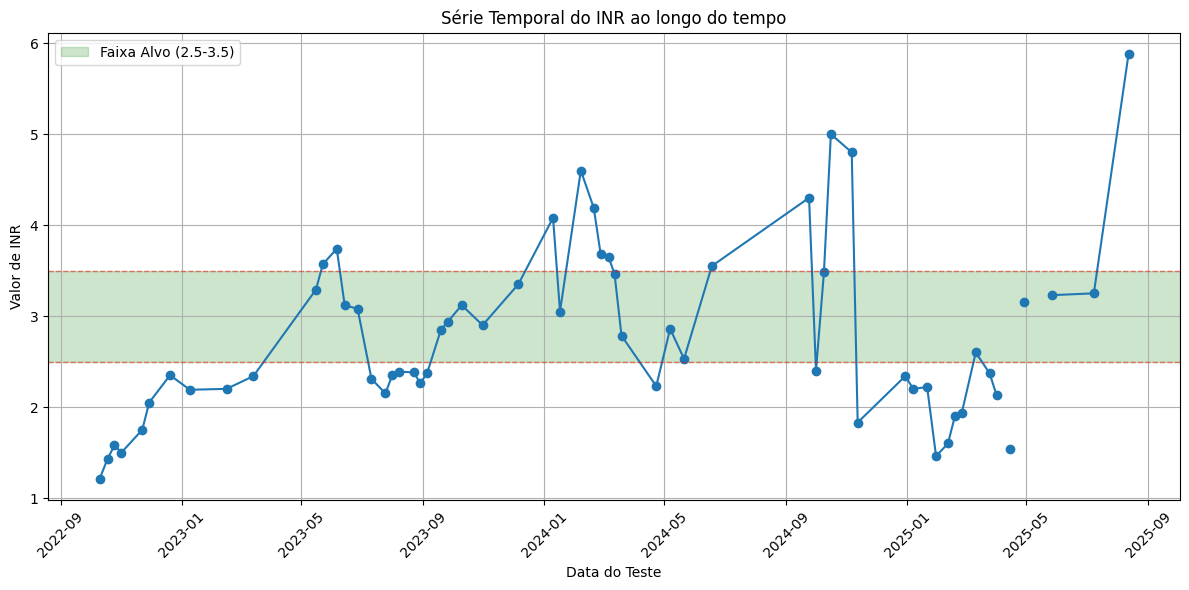

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data_filtred['test_date'], data_filtred['inr'], marker='o')

plt.axhspan(2.5, 3.5, alpha=0.2, color='green', label='Faixa Alvo (2.5-3.5)')
plt.axhline(y=2.5, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(y=3.5, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel("Data do Teste")
plt.ylabel("Valor de INR")
plt.title("Série Temporal do INR ao longo do tempo")
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
data_filtred.shape

(63, 6)

### 1.2 Formulação e utilização de classe para tratamento padronizado dos dados

In [47]:
paciente1 = INRDataManipulation(path=path1)
paciente2 = INRDataManipulation(path=path2)
paciente3 = INRDataManipulation(path=path3)
paciente4 = INRDataManipulation(path=path4)
data1 = paciente1.get_data()
data2 = paciente2.get_data()
data3 = paciente3.get_data()
data4 = paciente4.get_data()
display(data1['generated'].value_counts())
display(data1)
print(data1.info())

generated
1    89
0    60
Name: count, dtype: int64

,test_date,dose_semanal,inr,inr_diff,low_range,high_range,generated
0,2022-10-10,0.0,1.210,0.000,2.0,3.0,0
1,2022-10-17,20.0,1.430,0.220,2.0,3.0,0
2,2022-10-24,22.5,1.580,0.150,2.0,3.0,0
3,2022-10-31,25.0,1.500,-0.080,2.0,3.0,0
4,2022-11-07,25.0,1.571,0.071,2.0,3.0,1
...,...,...,...,...,...,...,...
144,2025-07-14,47.5,3.701,0.451,2.0,3.0,1
145,2025-07-21,47.5,4.227,0.526,2.0,3.0,1
146,2025-07-28,47.5,4.753,0.526,2.0,3.0,1
147,2025-08-04,47.5,5.279,0.526,2.0,3.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   test_date     149 non-null    datetime64[ns]
 1   dose_semanal  149 non-null    float64       
 2   inr           149 non-null    float64       
 3   inr_diff      149 non-null    float64       
 4   low_range     149 non-null    float64       
 5   high_range    149 non-null    float64       
 6   generated     149 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 8.3 KB
None


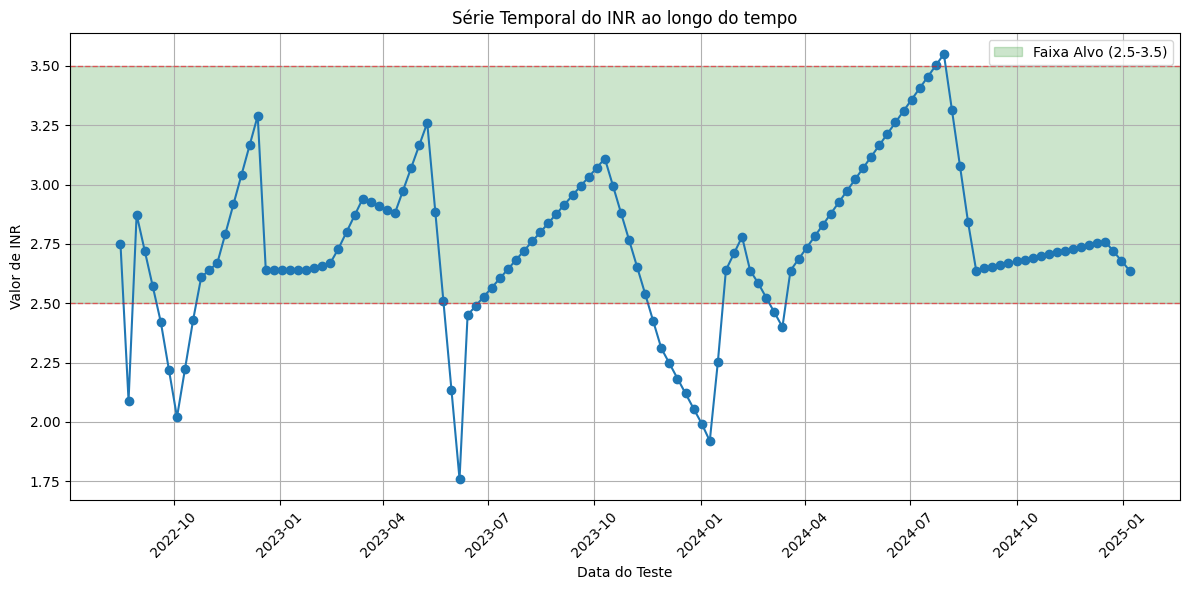

In [48]:
paciente4.plot_inr()

### 1.3 Criação de features e variáveis para a predição

weekofyear: número da semana ISO do ano — capta sazonalidade semanal e ciclos de rotina do paciente.

month: mês do ano — captura efeitos sazonais mensais (dieta, clima, eventos).

year: ano — identifica mudanças de regime/medicação/ambiente entre anos.

inr_lag_1, inr_lag_2, ... são os valores do INR das semanas anteriores.

inr_roll_mean_2, inr_roll_mean_4 são médias móveis dos últimos w valores (deslocadas 1 passo para evitar uso do próprio futuro).

In [49]:
def create_time_features(data, date_col="test_date", target_col="inr",
                         lags=[1,2,3,4], roll_windows=[2,4]):
    df = data.copy()

    # Features temporais 
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['month'] = df[date_col].dt.month.astype(int)
    df['year'] = df[date_col].dt.year.astype(int)

    # Lags do INR (DEPENDÊNCIA TEMPORAL DO ALVO)
    for lag in lags:
        df[f'inr_lag_{lag}'] = df[target_col].shift(lag)

    # Médias móveis (SUAVIZAÇÃO DA DINÂMICA DO INR)
    for w in roll_windows:
        # média dos últimos w valores, deslocada para evitar vazamento de informação
        df[f'inr_roll_mean_{w}'] = (df[target_col].shift(1).rolling(window=w, min_periods=1).mean())

    # Remoção das primeiras linhas sem lags suficientes 
    min_lag = max(lags) if len(lags) > 0 else 0
    df_features = df.iloc[min_lag:].reset_index(drop=True)

    # Seleção das features
    base_cols = ['dose_semanal', 'generated', 'weekofyear', 'month', 'dayofweek']

    lag_cols = [f'inr_lag_{lag}' for lag in lags]
    roll_cols = [f'inr_roll_mean_{w}' for w in roll_windows]

    feature_cols = base_cols + lag_cols + roll_cols

    # manter apenas colunas existentes
    feature_cols = [c for c in feature_cols if c in df_features.columns]

    return df_features, feature_cols

In [50]:
df1, fc1 = create_time_features(data1)
display(df1)
print("Features a serem analisadas:", fc1)

,test_date,dose_semanal,inr,inr_diff,low_range,high_range,generated,weekofyear,month,year,inr_lag_1,inr_lag_2,inr_lag_3,inr_lag_4,inr_roll_mean_2,inr_roll_mean_4
0,2022-11-07,25.0,1.571,0.071,2.0,3.0,1,45,11,2022,1.500,1.580,1.430,1.210,1.5400,1.43000
1,2022-11-14,25.0,1.655,0.083,2.0,3.0,1,46,11,2022,1.571,1.500,1.580,1.430,1.5355,1.52025
2,2022-11-21,27.5,1.750,0.095,2.0,3.0,0,47,11,2022,1.655,1.571,1.500,1.580,1.6130,1.57650
3,2022-11-28,30.0,2.050,0.300,2.0,3.0,0,48,11,2022,1.750,1.655,1.571,1.500,1.7025,1.61900
4,2022-12-05,30.0,2.136,0.086,2.0,3.0,1,49,12,2022,2.050,1.750,1.655,1.571,1.9000,1.75650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2025-07-14,47.5,3.701,0.451,2.0,3.0,1,29,7,2025,3.250,3.246,3.243,3.240,3.2480,3.24475
141,2025-07-21,47.5,4.227,0.526,2.0,3.0,1,30,7,2025,3.701,3.250,3.246,3.243,3.4755,3.36000
142,2025-07-28,47.5,4.753,0.526,2.0,3.0,1,31,7,2025,4.227,3.701,3.250,3.246,3.9640,3.60600
143,2025-08-04,47.5,5.279,0.526,2.0,3.0,1,32,8,2025,4.753,4.227,3.701,3.250,4.4900,3.98275


Features a serem analisadas: ['dose_semanal', 'generated', 'weekofyear', 'month', 'inr_lag_1', 'inr_lag_2', 'inr_lag_3', 'inr_lag_4', 'inr_roll_mean_2', 'inr_roll_mean_4']


In [51]:
TARGET_COL = "inr"
DATE_COL = "test_date"
TEST_SIZE_WEEKS = 0.2         # fração do conjunto final para teste
RANDOM_STATE = 42

X = df1[fc1].copy()
y = df1[TARGET_COL].copy()

display(X.head())
print(X.info())
print(y.head())
print(y.info())

,dose_semanal,generated,weekofyear,month,inr_lag_1,inr_lag_2,inr_lag_3,inr_lag_4,inr_roll_mean_2,inr_roll_mean_4
0,25.0,1,45,11,1.500,1.580,1.430,1.210,1.5400,1.43000
1,25.0,1,46,11,1.571,1.500,1.580,1.430,1.5355,1.52025
2,27.5,0,47,11,1.655,1.571,1.500,1.580,1.6130,1.57650
3,30.0,0,48,11,1.750,1.655,1.571,1.500,1.7025,1.61900
4,30.0,1,49,12,2.050,1.750,1.655,1.571,1.9000,1.75650


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dose_semanal     145 non-null    float64
 1   generated        145 non-null    int64  
 2   weekofyear       145 non-null    int64  
 3   month            145 non-null    int64  
 4   inr_lag_1        145 non-null    float64
 5   inr_lag_2        145 non-null    float64
 6   inr_lag_3        145 non-null    float64
 7   inr_lag_4        145 non-null    float64
 8   inr_roll_mean_2  145 non-null    float64
 9   inr_roll_mean_4  145 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 11.5 KB
None
0    1.571
1    1.655
2    1.750
3    2.050
4    2.136
Name: inr, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 145 entries, 0 to 144
Series name: inr
Non-Null Count  Dtype  
--------------  -----  
145 non-null    float64
dtypes: float64(1)
memory usage: 1.3 KB
None


In [52]:
# Separação treino/teste 
n_total = len(df1)
n_test = int(n_total * TEST_SIZE_WEEKS)
n_train = n_total - n_test
if n_test < 1:
    raise ValueError("Teste muito pequeno: aumente TEST_SIZE_WEEKS")

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
dates_train = df1[DATE_COL].iloc[:n_train]
dates_test = df1[DATE_COL].iloc[n_train:]

# Proximidade à faixa alvo (usando low/high do próprio df_features)
low_vals = df1['low_range'].iloc[n_train:].values
high_vals = df1['high_range'].iloc[n_train:].values

print(f"Observações: total={n_total}, train={len(X_train)}, test={len(X_test)}")

Observações: total=145, train=116, test=29


### 1.4 Funções de auxílio

In [ ]:
def plot_inr_prediction(dates, y_true, y_pred, low_vals, high_vals, title="INR Real x Previsto"):
    dates = np.array(dates)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Se low/high forem escalares, expandir
    if np.isscalar(low_vals):
        low_vals = np.full_like(y_pred, low_vals, dtype=float)
    if np.isscalar(high_vals):
        high_vals = np.full_like(y_pred, high_vals, dtype=float)

    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true, label='INR real', marker='o')
    plt.plot(dates, y_pred, label='INR previsto', marker='x')

    plt.fill_between(dates, low_vals, high_vals,
                     color='green', alpha=0.15, label='Faixa alvo')

    plt.xlabel("Data")
    plt.ylabel("INR")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_residuals(dates, y_true, y_pred, title="Modelo"):
    dates = np.array(dates)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    resid = y_true - y_pred
    
    # Plotagem dos resíduos
    plt.figure(figsize=(14, 4))
    plt.plot(dates, resid, marker='o')
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"Resíduos (real - previsto) – {title}")
    plt.xlabel("Data")
    plt.ylabel("Resíduo")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Histograma dos resíduos
    plt.figure(figsize=(8, 4))
    sns.histplot(resid, bins=25, kde=True)
    plt.title(f"Distribuição dos Resíduos – {title}")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()

In [111]:
def plot_xgb_feature_importance(model, top_n=15, importance_type="gain", title=None):
    # Extrair importâncias do modelo
    booster = model.get_booster()
    importance = booster.get_score(importance_type=importance_type)
    
    if len(importance) == 0:
        raise ValueError("O modelo não retornou importâncias. Verifique se foi treinado corretamente.")
    
    # Converter para DataFrame
    imp_df = (pd.DataFrame({
              "feature": list(importance.keys()),
              "value": list(importance.values())}).sort_values("value", ascending=True))  # para gráfico horizontal
    
    # Top-N
    imp_df = imp_df.tail(top_n)
    
    # Plotagem
    plt.figure(figsize=(20, 8))
    bars = plt.barh(imp_df["feature"], imp_df["value"])
    
    # Adicionar valores ao lado das barras
    max_val = imp_df["value"].max()
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + max_val * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.4f}",
            va="center"
        )
    
    # Labels e estética
    plt.xlabel(importance_type.capitalize())
    plt.title(title or f"Importância das Features ({importance_type.upper()}) – XGBoost")
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_lgb_feature_importance(model, feature_names=None, top_n=20, importance_type="gain", title=None, figsize=(12,8), show_values=True):
    # validar importance_type
    if importance_type not in ("gain", "split"):
        raise ValueError("importance_type deve ser 'gain' ou 'split'.")

    # detectar booster e extrair importâncias
    # caso model seja LGBMRegressor, extrair booster com model.booster_
    if hasattr(model, "booster_") and model.booster_ is not None:
        booster = model.booster_
    elif isinstance(model, object) and hasattr(model, "feature_name") and hasattr(model, "feature_importance"):
        # assume que já é um Booster-like
        booster = model
    else:
        # fallback: tentar usar model diretamente (p.ex. lgb.Booster)
        booster = model

    # tentativa segura de obter nomes e importâncias
    try:
        names = booster.feature_name()
    except Exception:
        names = None

    if feature_names is not None:
        names = feature_names

    try:
        # feature_importance com tipo (gain/split)
        vals = booster.feature_importance(importance_type=importance_type)
    except Exception as e:
        # fallback simples: tentar sem tipo
        try:
            vals = booster.feature_importance()
        except Exception as e2:
            raise RuntimeError(f"Não foi possível extrair importâncias do modelo LightGBM: {e}; fallback: {e2}")

    # se names ainda None, gerar nomes genéricos
    if names is None:
        names = [f"f{i}" for i in range(len(vals))]

    if len(names) != len(vals):
        # se houver inconsistência de shapes, truncar/expandir conforme necessário
        minlen = min(len(names), len(vals))
        names = names[:minlen]
        vals = vals[:minlen]

    imp_df = pd.DataFrame({"feature": names, "importance": vals})
    # remover zeros (opcional) - mantido aqui, mas você pode comentar a linha abaixo se preferir ver zeros
    imp_df = imp_df[imp_df["importance"] != 0.0]

    # ordenar e selecionar top_n
    imp_df = imp_df.sort_values("importance", ascending=True).tail(top_n)

    # plot
    plt.figure(figsize=figsize)
    bars = plt.barh(imp_df["feature"], imp_df["importance"], color="C0", alpha=0.9)
    if show_values and not imp_df["importance"].empty:
        max_val = imp_df["importance"].max()
        for bar in bars:
            width = bar.get_width()
            plt.text(width + max_val * 0.01, bar.get_y() + bar.get_height()/2,
                     f"{width:.4f}", va="center", fontsize=9)

    plt.xlabel(importance_type.capitalize())
    plt.title(title or f"Importância das features (LightGBM) — top {len(imp_df)}")
    plt.grid(axis="x", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()

    #return imp_df

def plot_rf_feature_importance(model, feature_names, top_n=20, title="Importância das Features – RandomForest", figsize=(12,8), show_values=True):
    # Garantir consistência
    importances = model.feature_importances_
    if len(importances) != len(feature_names):
        raise ValueError("Tamanho de feature_names não corresponde ao número de importâncias do modelo.")

    # Construção do DataFrame
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=True)

    # Seleção das top_n
    imp_df = imp_df.tail(top_n)

    # Plotagem
    plt.figure(figsize=figsize)
    bars = plt.barh(imp_df["feature"], imp_df["importance"], color="steelblue")

    # Adicionar valores ao lado das barras
    if show_values:
        max_val = imp_df["importance"].max()
        for bar in bars:
            width = bar.get_width()
            plt.text(width + max_val * 0.01,
                     bar.get_y() + bar.get_height()/2,
                     f"{width:.4f}",
                     va='center',
                     fontsize=9)

    # Estética
    plt.title(title)
    plt.xlabel("Importância (Gini / MSE Reduction)")
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    #return imp_df

#### Função fora de uso, por enquanto

In [ ]:
def plot_feature_importance(model,
                            feature_names=None,
                            top_n: int = 15,
                            importance_type: str = "gain",
                            title: str | None = None,
                            figsize=(12, 6),
                            show_values=True):
    """
    Plot de importância de features compatível com:
      - XGBoost (model.get_booster().get_score)
      - LightGBM (model.booster_.feature_importance / model.feature_importance)
      - RandomForest / ExtraTrees / sklearn ensembles (model.feature_importances_)
      - CatBoost (model.get_feature_importance)
    Parâmetros
    ----------
    model: objeto treinado (XGBRegressor, LGBMRegressor, RandomForestRegressor, CatBoost, etc.)
    feature_names: list[str] ou None -> lista de nomes das features na ordem das colunas usadas no treino.
                   Se None, tentaremos obter nomes do modelo (quando possível).
    top_n: int -> quantas features exibir (top N).
    importance_type: str -> preferência por tipo de importância: 'gain', 'split', 'weight', ...
                   Essa preferência é tentada quando o modelo suporta (XGBoost/LightGBM).
                   Para sklearn RF o parâmetro é ignorado (usa feature_importances_).
    title: str opcional -> título do gráfico.
    figsize: tupla -> tamanho da figura.
    show_values: se True adiciona o valor numérico ao lado das barras.
    Retorna
    -------
    imp_df: pd.DataFrame com colunas ['feature','importance'] ordenado ascendente (pronto para barh).
    """
    # ---------- Helpers ----------
    def _from_xgb(m, itype):
        booster = m.get_booster()
        # XGBoost get_score retorna dict {f"f{i}": value}, onde keys referenciam feature indices usadas internamente.
        score = booster.get_score(importance_type=itype)
        if not score:
            # fallback para default importance (weight)
            score = booster.get_score(importance_type='weight')
        # score keys podem ser 'f0','f1'... precisamos mapear para feature_names se fornecidos
        return score

    def _from_lgb(m, itype):
        # lgb.Booster or LGBMRegressor
        try:
            booster = getattr(m, "booster_", None)
            if booster is not None:
                vals = booster.feature_importance(importance_type=itype)
                names = booster.feature_name()
            else:
                # LGBMRegressor também tem feature_importance
                vals = m.feature_importance(importance_type=itype)
                names = m.booster_.feature_name() if hasattr(m, "booster_") else feature_names
            return dict(zip(names, vals))
        except Exception:
            # fallback: try default feature_importance with no type
            try:
                vals = m.feature_importance()
                names = feature_names
                return dict(zip(names, vals))
            except Exception:
                return {}

    def _from_sklearn(m):
        if hasattr(m, "feature_importances_"):
            vals = m.feature_importances_
            # feature_names must be provided ideally
            return dict(zip(feature_names if feature_names is not None else [f"f{i}" for i in range(len(vals))], vals))
        return {}

    def _from_catboost(m, itype):
        try:
            # CatBoost: get_feature_importance(type='FeatureImportance' or 'LossFunctionChange')
            vals = m.get_feature_importance(type=itype if itype in ("FeatureImportance", "LossFunctionChange") else "FeatureImportance")
            names = feature_names if feature_names is not None else [f"f{i}" for i in range(len(vals))]
            return dict(zip(names, vals))
        except Exception:
            return {}

    # ---------- Detecção do modelo e extração ----------
    importance_dict = {}
    model_name = type(model).__name__.lower()

    # tentar extrair feature names do modelo se não fornecido
    if feature_names is None:
        # xgboost XGBRegressor tem feature_names_in_ quando treinado a partir de DataFrame scikit-learn
        if hasattr(model, "feature_name") and callable(getattr(model, "feature_name")):
            try:
                feature_names = model.feature_name()
            except Exception:
                feature_names = None
        elif hasattr(model, "feature_names_in_"):
            try:
                feature_names = list(model.feature_names_in_)
            except Exception:
                feature_names = None
        elif hasattr(model, "booster_") and hasattr(model.booster_, "feature_name"):
            try:
                feature_names = model.booster_.feature_name()
            except Exception:
                feature_names = None

    # XGBoost
    if hasattr(model, "get_booster") and callable(getattr(model, "get_booster")):
        # map keys f0,f1,... to feature_names if available
        raw = _from_xgb(model, importance_type if importance_type in ("gain","weight","cover","total_gain","total_cover") else "gain")
        # raw keys like 'f0' mapping:
        if feature_names is not None:
            # construir mapping f{i} -> feature_names[i]
            mapped = {}
            for k, v in raw.items():
                if isinstance(k, str) and k.startswith("f"):
                    try:
                        idx = int(k[1:])
                        name = feature_names[idx] if idx < len(feature_names) else k
                    except Exception:
                        name = k
                else:
                    name = k
                mapped[name] = v
            importance_dict = mapped
        else:
            # sem feature_names, devolver raw keys
            importance_dict = raw

    # LightGBM
    elif (hasattr(model, "booster_") or model.__class__.__module__.startswith("lightgbm")):
        # lightgbm LGBMRegressor or Booster
        importance_dict = _from_lgb(model, importance_type if importance_type in ("gain","split") else "gain")

    # CatBoost
    elif model_name.startswith("catboost") or hasattr(model, "get_feature_importance"):
        importance_dict = _from_catboost(model, "FeatureImportance")

    # sklearn-like ensembles (RandomForest, ExtraTrees)
    elif hasattr(model, "feature_importances_"):
        if feature_names is None:
            # build generic names
            vals = model.feature_importances_
            names = [f"f{i}" for i in range(len(vals))]
            importance_dict = dict(zip(names, vals))
        else:
            importance_dict = dict(zip(feature_names, model.feature_importances_))

    else:
        raise ValueError("Tipo de modelo não suportado automaticamente para extração de importâncias. "
                         "Forneça feature_names e/ou extraia manualmente as importâncias.")

    # ---------- Preparar DataFrame ordenado ----------
    if not importance_dict:
        raise ValueError("Não foi possível extrair importâncias do modelo (dicionário vazio).")

    imp_df = pd.DataFrame({
        "feature": list(importance_dict.keys()),
        "importance": list(importance_dict.values())
    })

    # remover constantes / zeros se quiser (opcional)
    imp_df = imp_df[imp_df["importance"] != 0.0]

    imp_df = imp_df.sort_values("importance", ascending=True).tail(top_n)

    # ---------- Plot ----------
    plt.figure(figsize=figsize)
    bars = plt.barh(imp_df["feature"], imp_df["importance"], color="C0", alpha=0.9)

    if show_values:
        max_val = imp_df["importance"].max() if not imp_df["importance"].empty else 1.0
        for bar in bars:
            width = bar.get_width()
            plt.text(width + max_val * 0.01,
                     bar.get_y() + bar.get_height() / 2,
                     f"{width:.4f}",
                     va="center", fontsize=9)

    plt.xlabel((importance_type or "importance").capitalize())
    plt.title(title or f"Feature importance (top {top_n})")
    plt.grid(axis="x", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()

    return imp_df

# 1) XGBoost (supondo que 'model_xgb' foi treinado com DataFrame que tem feature_names)
imp_df = plot_feature_importance(model_xgb, feature_names=fc1, top_n=15, importance_type="gain")

# 2) LightGBM
imp_df = plot_feature_importance(model_lgb, feature_names=fc1, top_n=20, importance_type="gain")

# 3) RandomForest (sklearn) - importance_type é ignorado, usa feature_importances_
imp_df = plot_feature_importance(model_rf, feature_names=fc1, top_n=15)

## 2. Treinando XGBoost

### 2.1 XGBoost com hyperparâmentros fixos

In [61]:
modelxgb = xgb.XGBRegressor(n_estimators = 200,
                         max_depth = 4,
                         learning_rate = 0.05,
                         subsample = 0.8,
                         colsample_bytree = 0.8,
                         random_state = RANDOM_STATE,
                         verbosity = 0)

modelxgb.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             verbose=False)

# Previsões
y_pred_train = modelxgb.predict(X_train)
y_pred_test = modelxgb.predict(X_test)

# Erros
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")

MAE train: 0.0276 | MAE test: 0.3671
RMSE train: 0.0014 | RMSE test: 0.2695


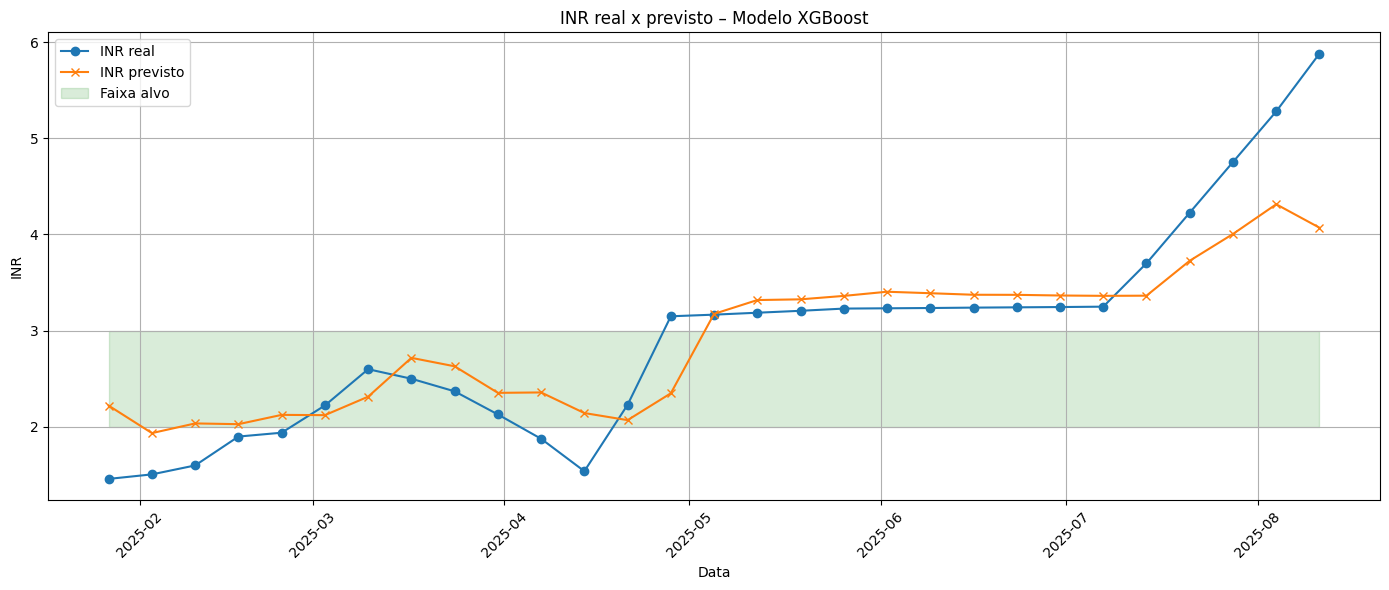

In [62]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo XGBoost")

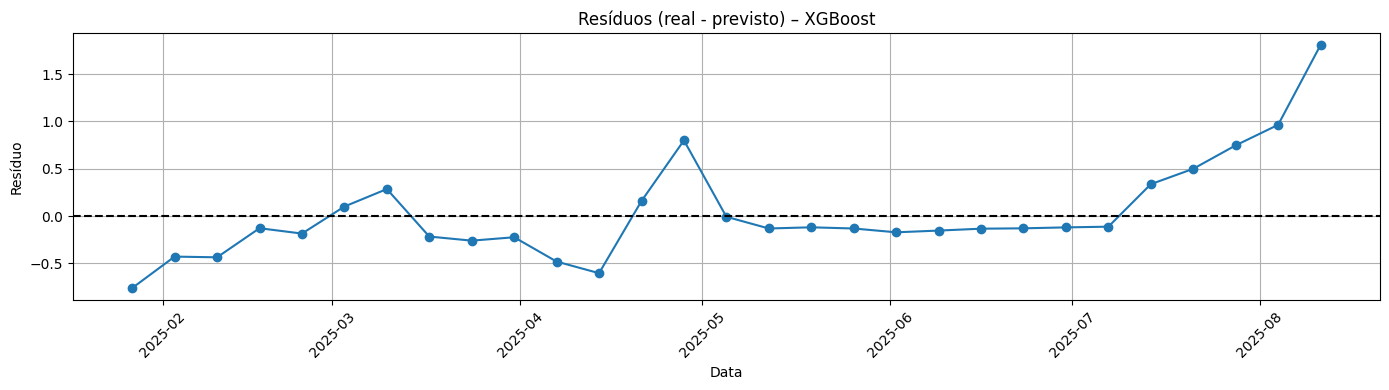

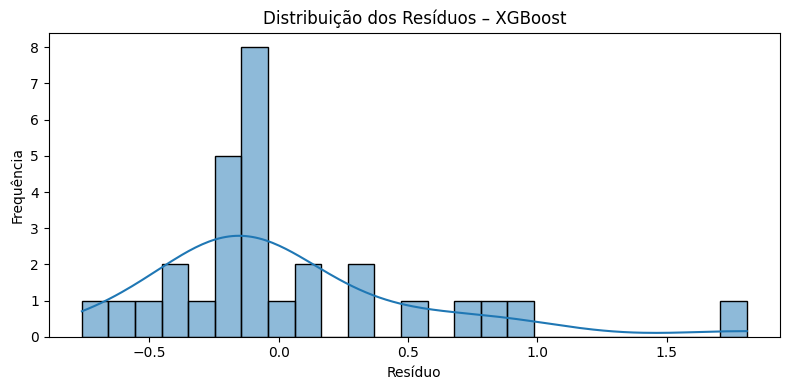

In [64]:
plot_residuals(dates_test, y_test.values, y_pred_test, title="XGBoost")

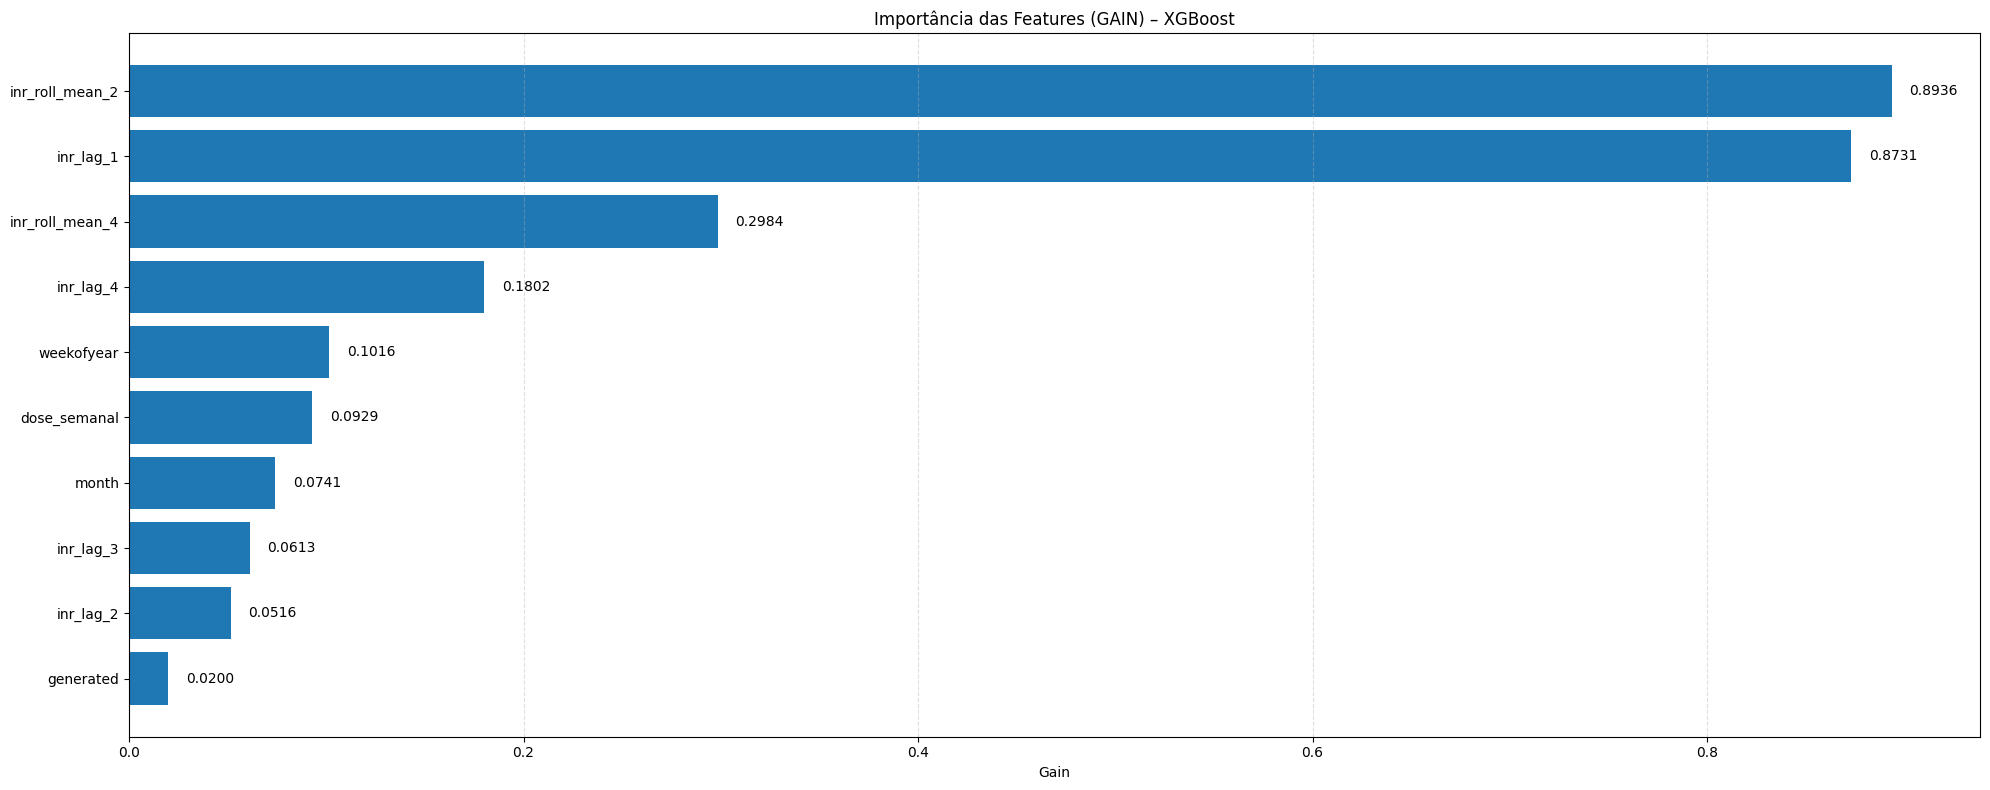

In [65]:
plot_xgb_feature_importance(modelxgb, top_n=15)

### 2.2 XGBoost com GridSearch

In [66]:
# Time series split para validação temporal
tscv = TimeSeriesSplit(n_splits=5)

model_xgb = xgb.XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror")

# Parâmetros para testar 
param_grid = {
    "n_estimators": [100, 200, 400, 600, 1000],
    "max_depth": [3, 4, 5, 6, 10],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "gamma": [0, 1],
    "min_child_weight": [1, 3, 5]
}

start = time.time()
print("Iniciando GridSearchCV com validação temporal...")

grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

end = time.time()
print(f"Tempo de treinamento: {end - start:.2f} segundos")

print("\n===== RESULTADO DO TUNING =====")
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print(f"MAE médio (validação): {-grid_search.best_score_:.4f}")

best_params = grid_search.best_params_

Iniciando GridSearchCV com validação temporal...
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Tempo de treinamento: 71.43 segundos

===== RESULTADO DO TUNING =====
Melhores parâmetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
MAE médio (validação): 0.4148


In [70]:
# Treinar modelo final com melhores parâmetros
model_xgb = xgb.XGBRegressor(**best_params,
                             random_state=RANDOM_STATE,
                             objective="reg:squarederror",
                             verbosity=0)

model_xgb.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [71]:
# Previsões
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

# Métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")

MAE train: 0.0948 | MAE test: 0.3695
RMSE train: 0.0388 | RMSE test: 0.2879


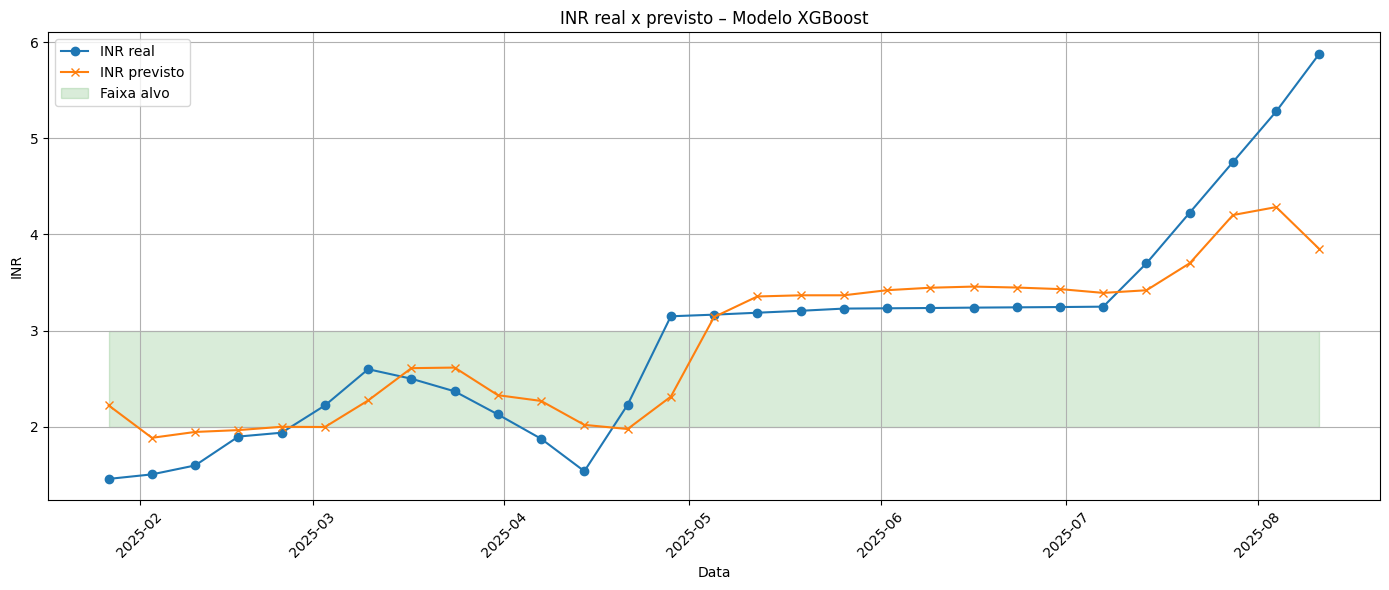

In [72]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo XGBoost")

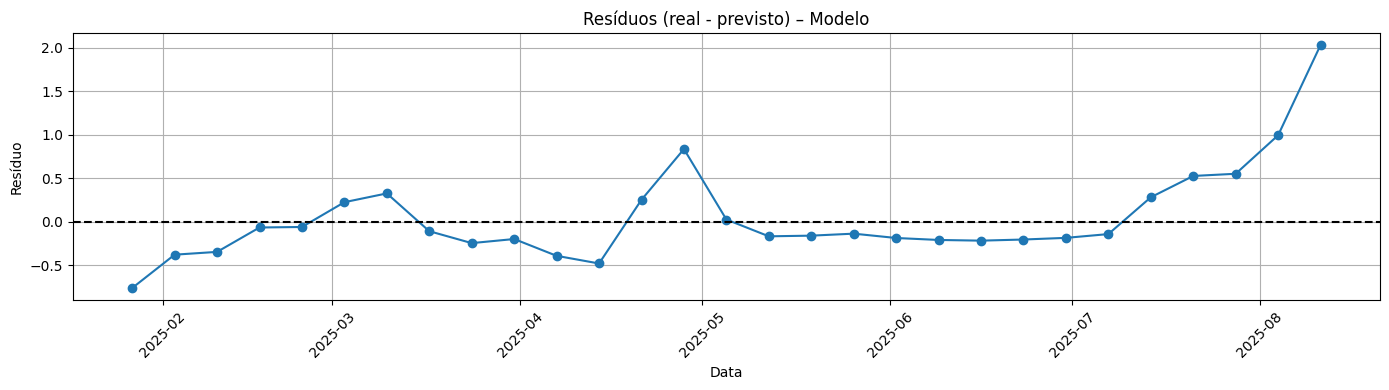

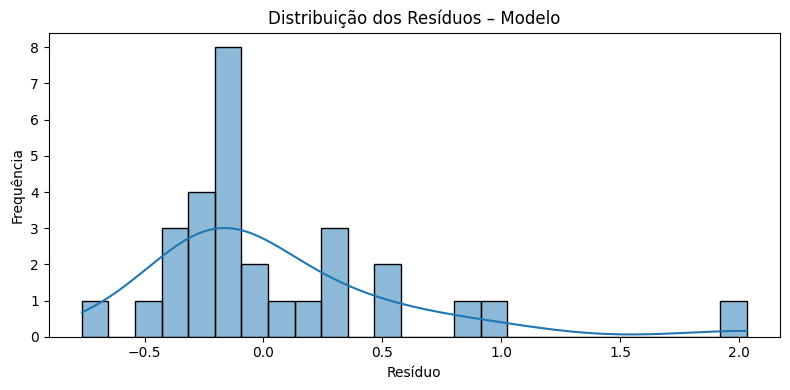

In [73]:
plot_residuals(dates_test, y_test.values, y_pred_test)

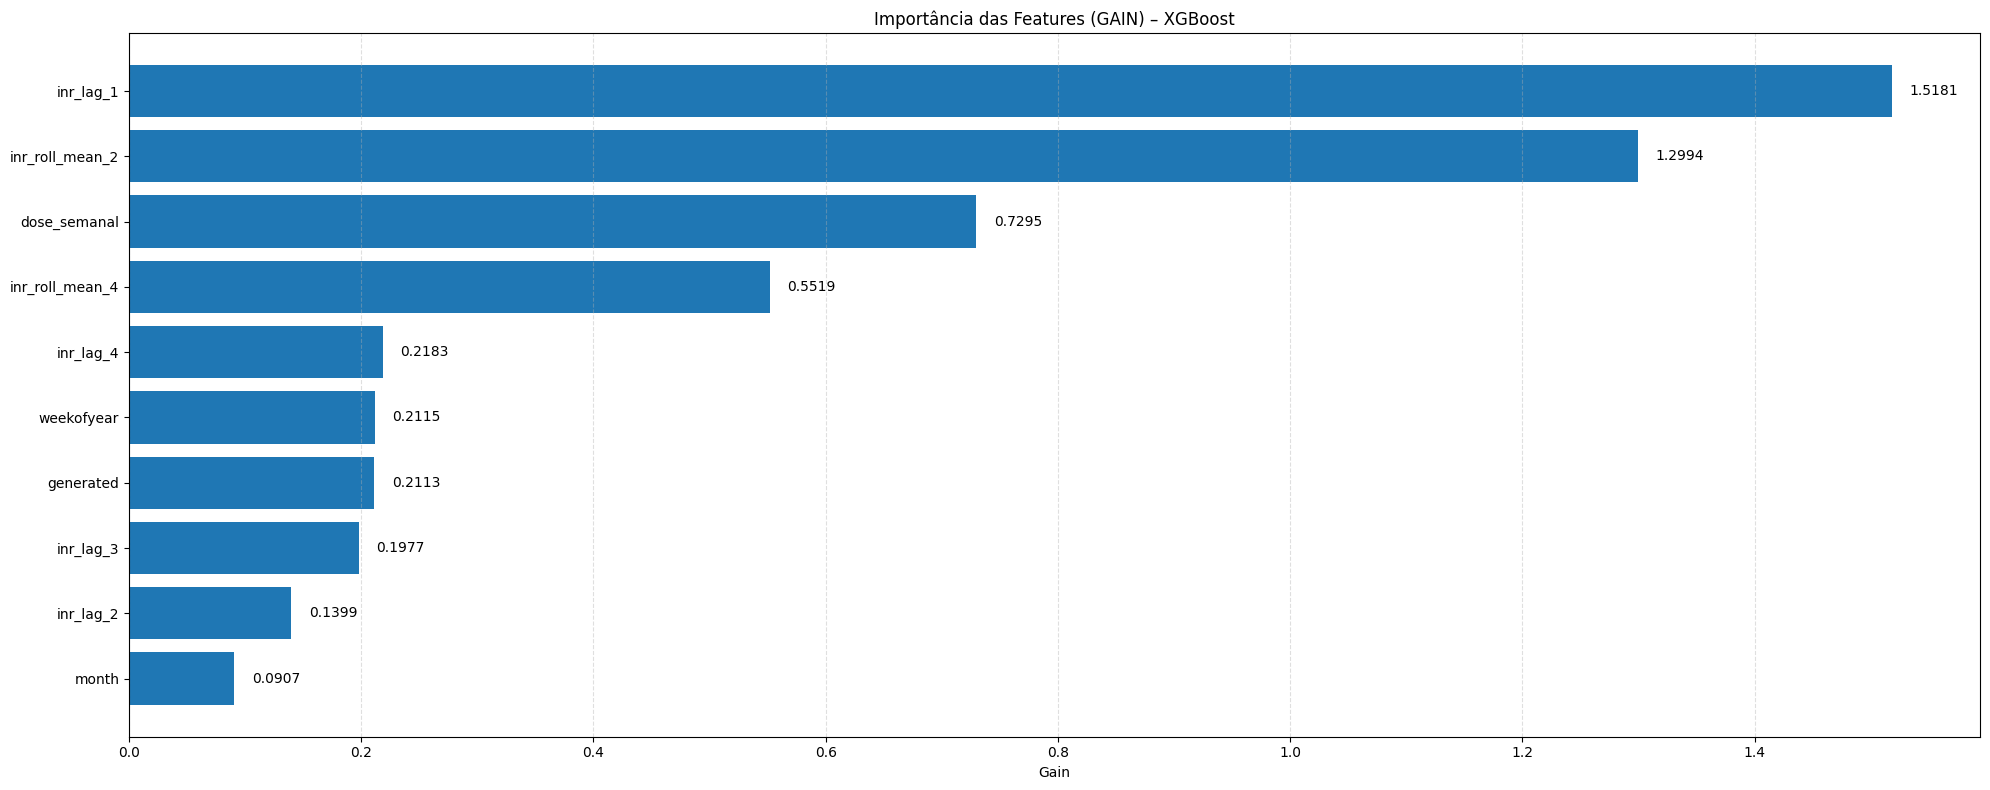

In [74]:
plot_xgb_feature_importance(model_xgb, top_n=15)

## 3. Treinando LightGBM

### 3.1 LightGBM com hiperparâmetros fixos

In [91]:
modellgb = lgb.LGBMRegressor(n_estimators = 1000,
                          learning_rate = 0.05,
                          num_leaves = 31,
                          max_depth = -1,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          reg_alpha = 0.0,
                          reg_lambda = 0.0,
                          random_state = RANDOM_STATE,
                          n_jobs = -1)


modellgb.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric="mae",)

y_pred_train = modellgb.predict(X_train, num_iteration=modellgb.best_iteration_)
y_pred_test  = modellgb.predict(X_test,  num_iteration=modellgb.best_iteration_)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test, y_pred_test)

print("==== Métricas ====")
print(f"MAE (train): {mae_train:.4f} | MAE (test): {mae_test:.4f}")
print(f"RMSE(train): {rmse_train:.4f} | RMSE(test): {rmse_test:.4f}")

==== Métricas ====
MAE (train): 0.0862 | MAE (test): 0.3943
RMSE(train): 0.0254 | RMSE(test): 0.3427


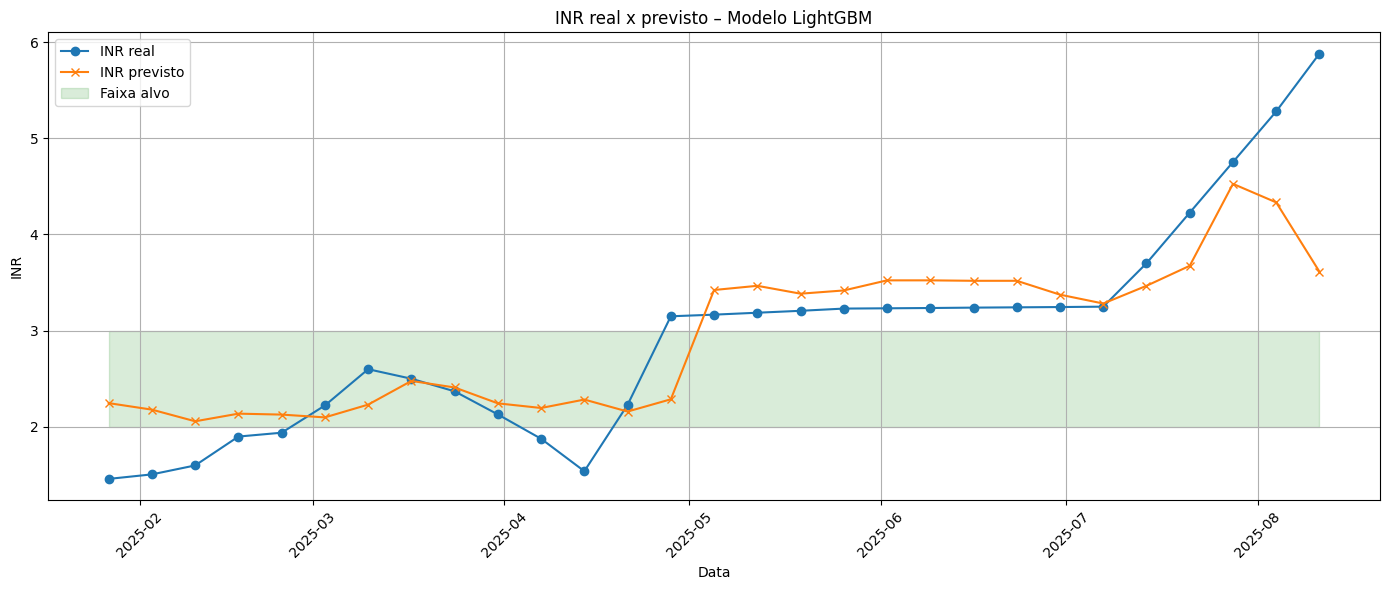

In [92]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo LightGBM")

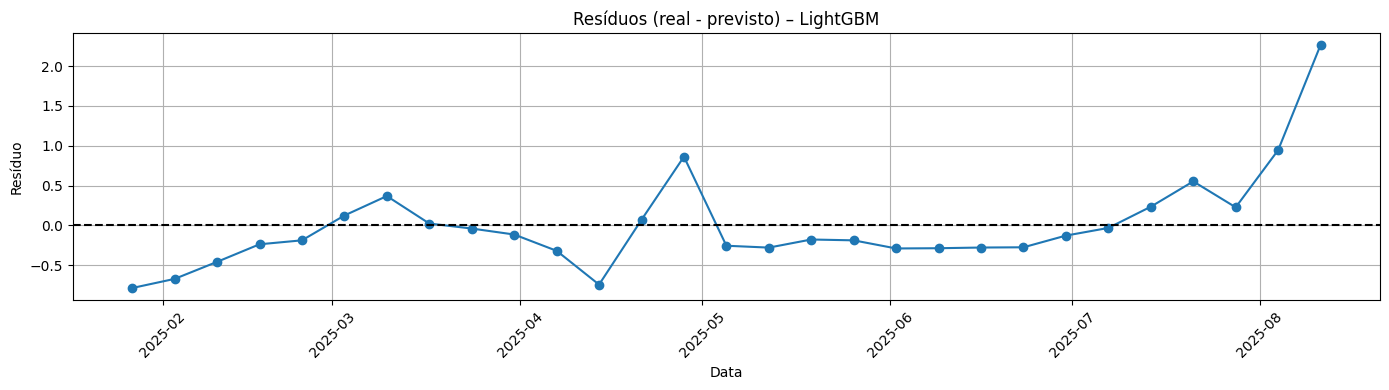

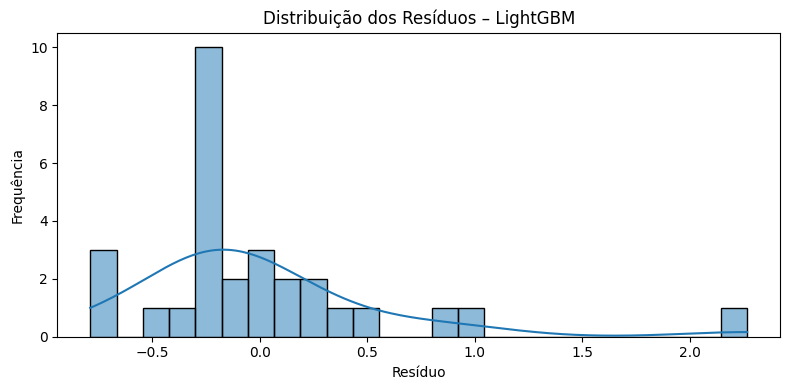

In [93]:
plot_residuals(dates_test, y_test.values, y_pred_test, title="LightGBM")

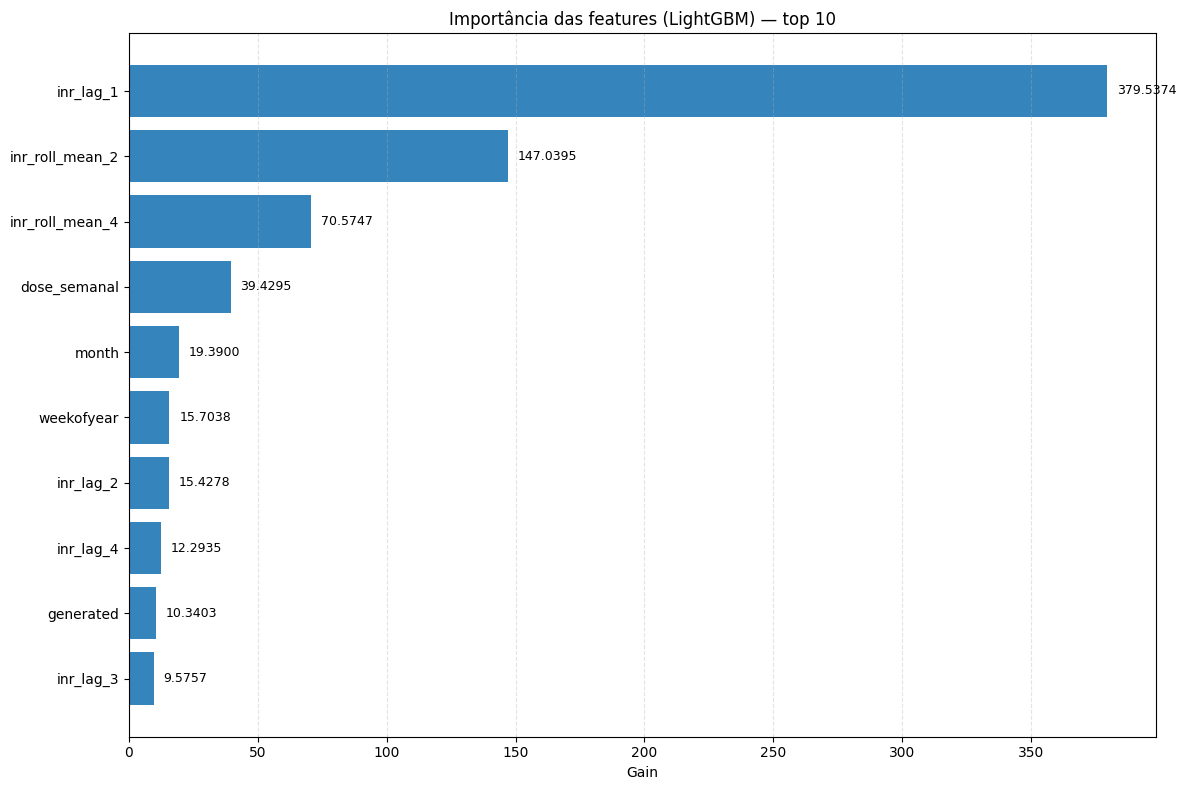

In [94]:
plot_lgb_feature_importance(modellgb, feature_names=fc1, top_n=15)

### 3.2 LightGBM com GridSearch

In [130]:
tscv = TimeSeriesSplit(n_splits=5)

base_params = {
    "objective": "regression",
    "metric": "mae",
    "random_state": RANDOM_STATE,
    "n_jobs": 1, 
    "verbosity": -1
}
lgb_est = lgb.LGBMRegressor(**base_params)

start = time.time()
print("\n=== Iniciando GridSearchCV (TimeSeriesSplit) ===")

param_grid = {
    "n_estimators": [100, 200, 500, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "num_leaves": [31, 63],
    "max_depth": [-1, 6],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0.0, 0.1],
    "reg_lambda": [0.0, 0.1]
}

grid = GridSearchCV(
    estimator=lgb_est,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

end = time.time()
print(f"Tempo de treinamento: {end - start:.2f} segundos")

grid_best_params = grid.best_params_
print("GridSearchCV best params:", grid_best_params)
print("GridSearchCV best CV MAE (neg):", grid.best_score_)


=== Iniciando GridSearchCV (TimeSeriesSplit) ===
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Tempo de treinamento: 16.46 segundos
GridSearchCV best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample': 0.8}
GridSearchCV best CV MAE (neg): -0.53361093647488


In [131]:
"""
# OPTUNA (recomendado)
optuna_best_params = None

# função objetivo que usa cross_val_score com TimeSeriesSplit e scoring MAE
def objective(trial):
    # espaço de busca (defina limites razoáveis)
    param = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "random_state": RANDOM_STATE,
        "n_jobs": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }

    # usar cross_val_score com TimeSeriesSplit (scoring negativo MAE) — média dos folds
    model = lgb.LGBMRegressor(**param)
    # cross_val_score retornará array de scores (neg MAE)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=1)
    # queremos maximizar score (neg MAE) -> optuna maximiza por default se retornamos value; porém minimizamos MAE.
    # retornar média negativa (neg MAE) é compatível: optuna busca maximizar value; então retornar mean(scores)
    return float(np.mean(scores))

print("\n=== Iniciando Optuna (TimeSeriesSplit) ===")

# Criar estudo buscando maximizar neg MAE -> equivalente a minimizar MAE
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

print("Optuna best value (neg MAE mean):", study.best_value)
optuna_best_params = study.best_trial.params.copy()
# alguns parâmetros são contínuos na busca, mas LGBM espera ints; coerção:
optuna_best_params_converted = {
    **{k: int(v) if k in ["n_estimators", "num_leaves", "max_depth", "min_child_samples"] else v
        for k, v in optuna_best_params.items()}
}
print("Optuna best params (raw):", optuna_best_params)
print("Optuna best params (converted):", optuna_best_params_converted)"""

'\n# OPTUNA (recomendado)\noptuna_best_params = None\n\n# função objetivo que usa cross_val_score com TimeSeriesSplit e scoring MAE\ndef objective(trial):\n    # espaço de busca (defina limites razoáveis)\n    param = {\n        "objective": "regression",\n        "metric": "mae",\n        "verbosity": -1,\n        "random_state": RANDOM_STATE,\n        "n_jobs": 1,\n        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),\n        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),\n        "num_leaves": trial.suggest_int("num_leaves", 16, 128),\n        "max_depth": trial.suggest_int("max_depth", 3, 12),\n        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),\n        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),\n        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),\n        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),\n        "min_child_samples": trial.suggest_int("min_chi

In [132]:
"""
# Escolher parâmetros finais
if optuna_best_params_converted is not None:
    final_params = {**base_params, **optuna_best_params_converted}
elif grid_best_params is not None:
    final_params = {**base_params, **grid_best_params}
else:
    # fallback razoável (padrão)
    final_params = {
        **base_params,
        "n_estimators": 500,
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_depth": -1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0
    }

print("\nFinal training params:")
print(final_params)"""

'\n# Escolher parâmetros finais\nif optuna_best_params_converted is not None:\n    final_params = {**base_params, **optuna_best_params_converted}\nelif grid_best_params is not None:\n    final_params = {**base_params, **grid_best_params}\nelse:\n    # fallback razoável (padrão)\n    final_params = {\n        **base_params,\n        "n_estimators": 500,\n        "learning_rate": 0.05,\n        "num_leaves": 31,\n        "max_depth": -1,\n        "subsample": 0.8,\n        "colsample_bytree": 0.8,\n        "reg_alpha": 0.0,\n        "reg_lambda": 0.0\n    }\n\nprint("\nFinal training params:")\nprint(final_params)'

In [133]:
# Treinar modelo final no conjunto de treino inteiro
model_lgb = lgb.LGBMRegressor(**grid_best_params) # final_params
model_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="mae")

y_pred_train = model_lgb.predict(X_train, num_iteration=model_lgb.best_iteration_)
y_pred_test  = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration_)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test, y_pred_test)

print("\n=== Resultados finais ===")
print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")


=== Resultados finais ===
MAE train: 0.1330 | MAE test: 0.4206
RMSE train: 0.0534 | RMSE test: 0.3620


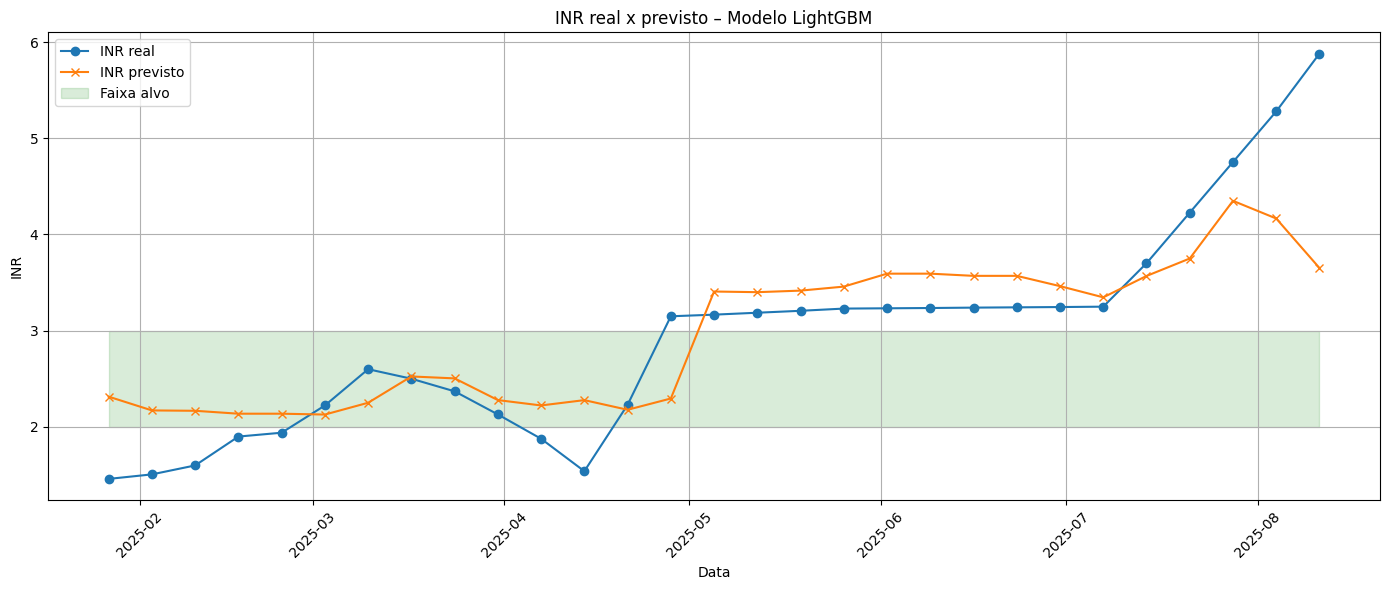

In [134]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo LightGBM")

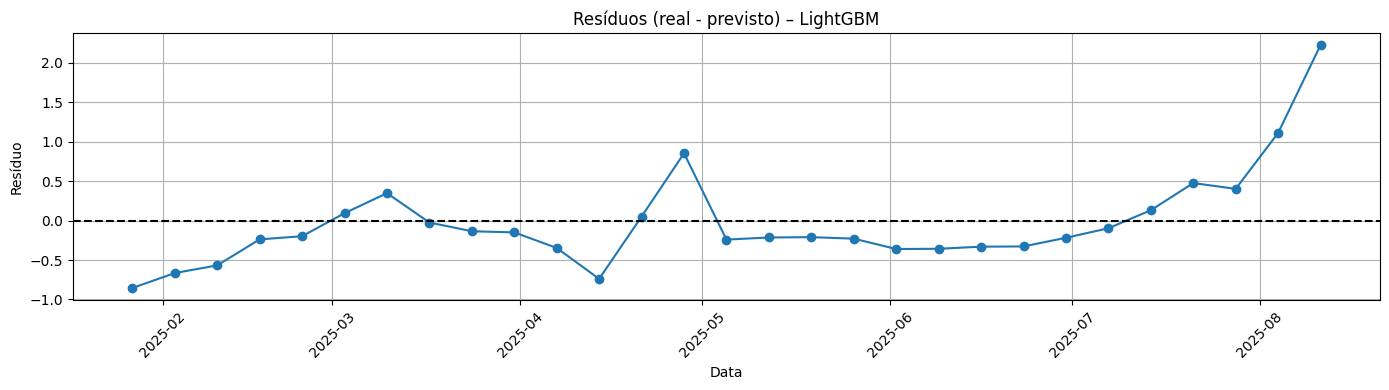

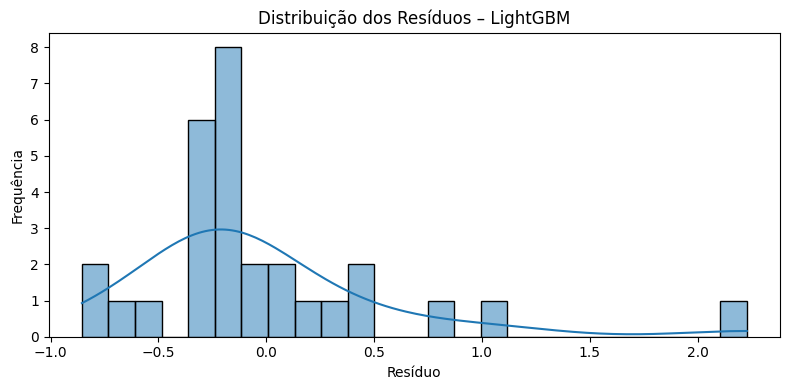

In [135]:
plot_residuals(dates_test, y_test.values, y_pred_test, title="LightGBM")

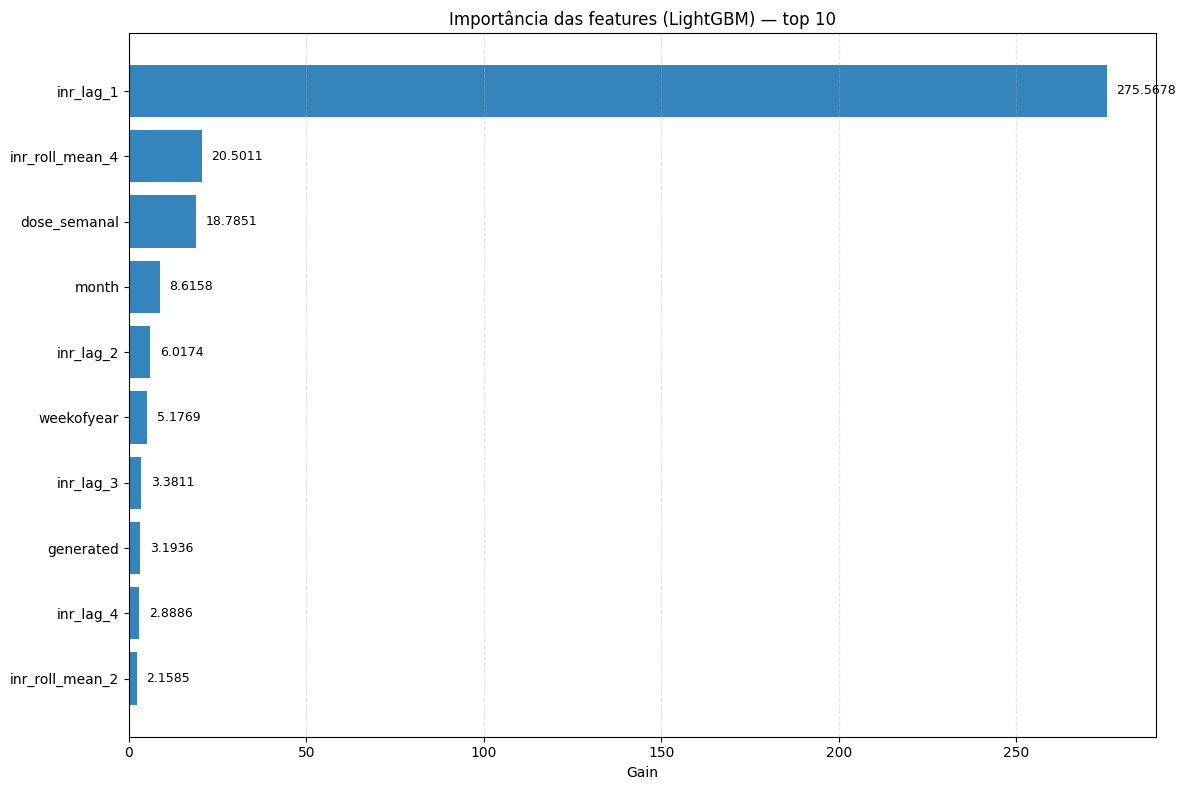

In [136]:
plot_lgb_feature_importance(model_lgb, feature_names=fc1, top_n=15)

## 4. Treinando RandomForest

### 4.1  RandomForest com hiperparâmetros fixos

In [112]:
# Hiperparâmetros fixos do RandomForest
RF_PARAMS = {
    "n_estimators": 200,         # número de árvores
    "max_depth": 8,              # profundidade máxima
    "min_samples_split": 5,
    "min_samples_leaf": 3,
    "max_features": "sqrt",      # número de features a considerar em cada split
    "n_jobs": -1,
    "random_state": RANDOM_STATE
}
# Treinamento do RandomForest
rf = RandomForestRegressor(**RF_PARAMS)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test,  y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test,  y_pred_test)

print("\nMétricas:")
print(f"MAE (train): {mae_train:.4f} | MAE (test): {mae_test:.4f}")
print(f"RMSE(train): {rmse_train:.4f} | RMSE(test): {rmse_test:.4f}")


Métricas:
MAE (train): 0.1528 | MAE (test): 0.4091
RMSE(train): 0.0821 | RMSE(test): 0.3417


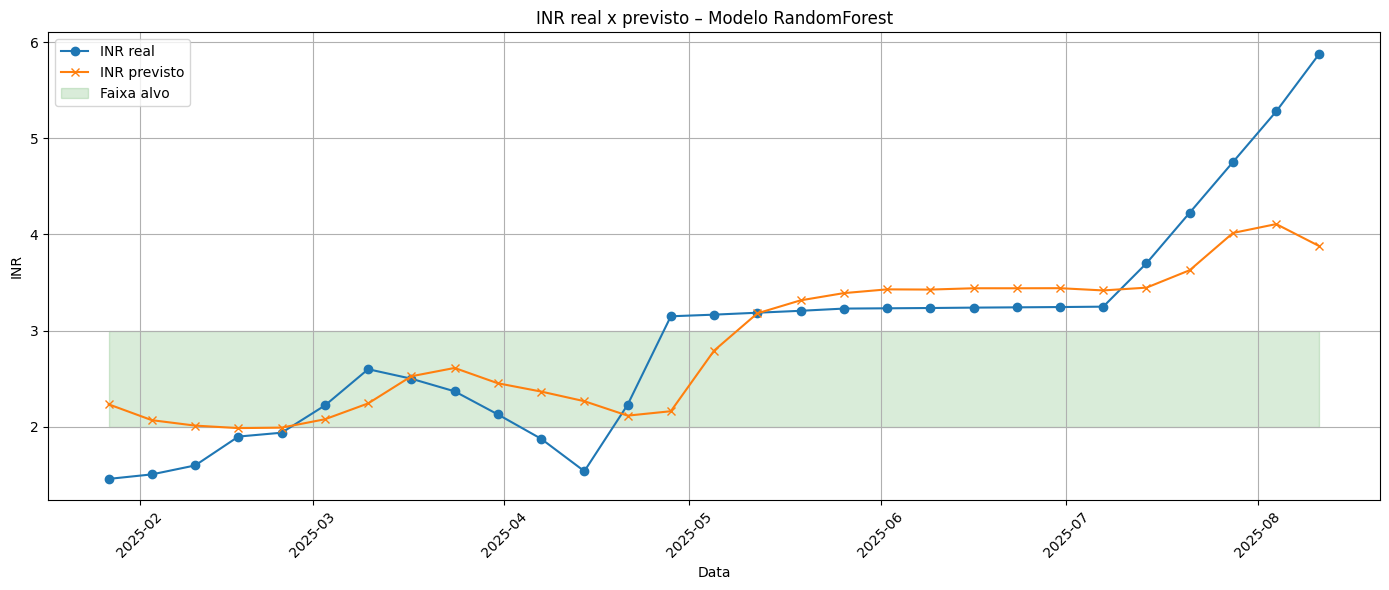

In [113]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo RandomForest")

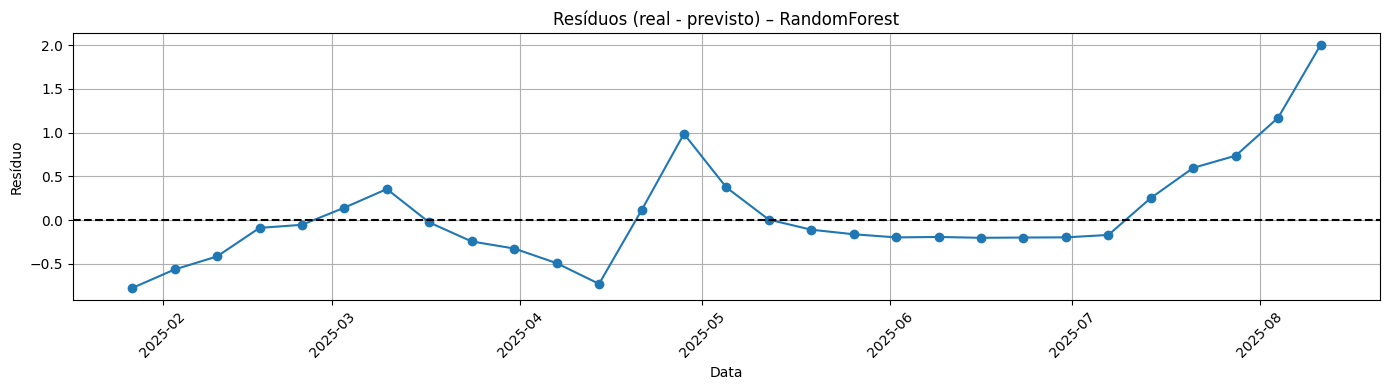

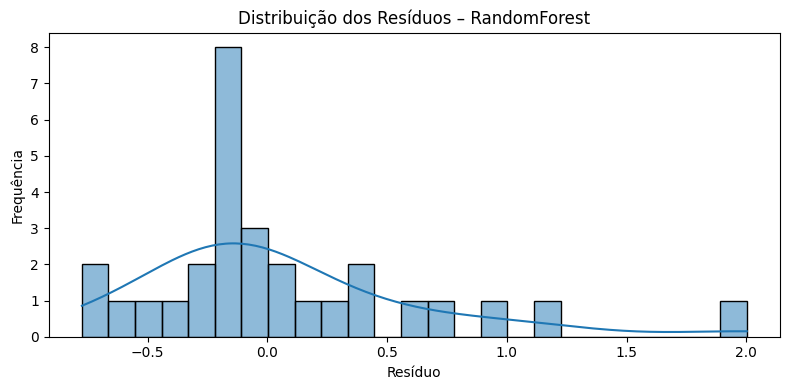

In [114]:
plot_residuals(dates_test, y_test.values, y_pred_test, title="RandomForest")

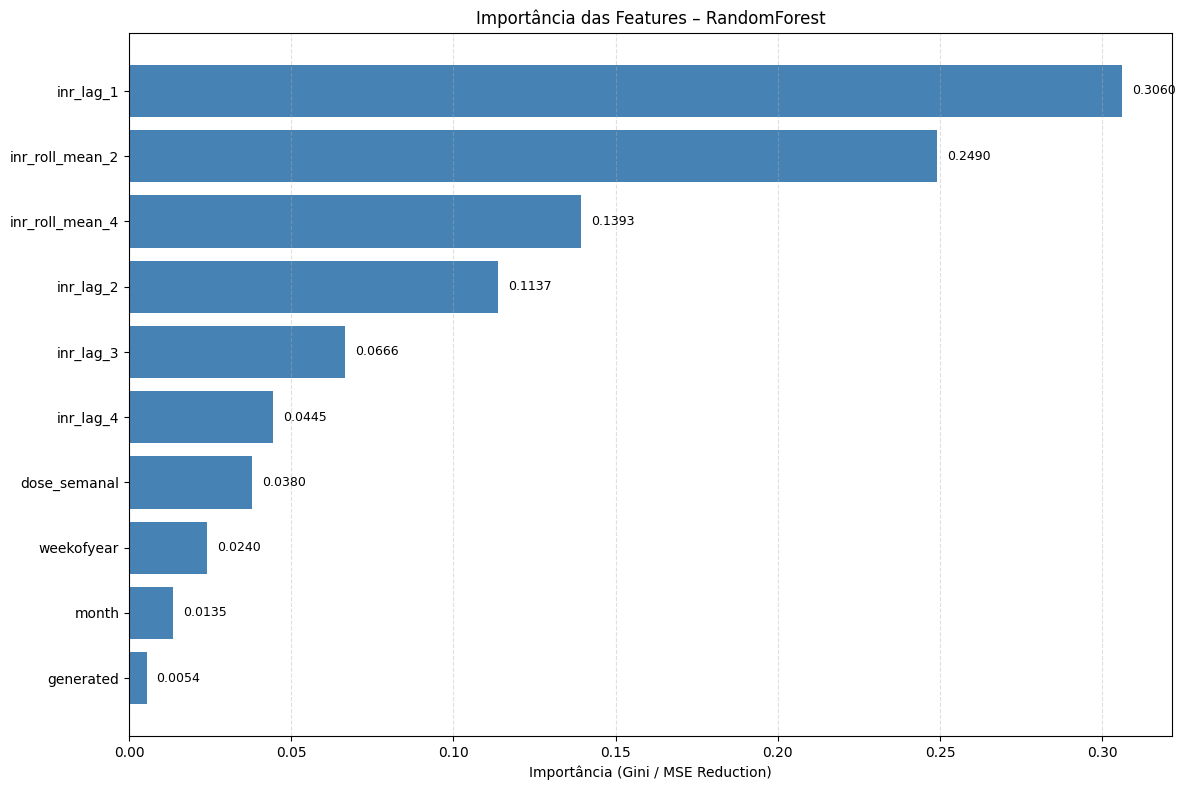

In [115]:
plot_rf_feature_importance(rf, feature_names=fc1, top_n=15)

### 4.2 RandomForest com GridSearch

In [119]:
TS_SPLITS = 5

# Grid inicial 
param_grid = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [3, 6, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", 0.5]
}

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=RANDOM_STATE)

start = time.time()
print("\n=== Iniciando GridSearchCV (TimeSeriesSplit) ===")

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid.fit(X_train, y_train)

end = time.time()
print(f"Tempo de treinamento: {end - start:.2f} segundos")

grid_best_params = grid.best_params_
print("GridSearchCV best params:", grid_best_params)
print("GridSearchCV best CV MAE (neg):", grid.best_score_)


=== Iniciando GridSearchCV (TimeSeriesSplit) ===
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Tempo de treinamento: 39.95 segundos
GridSearchCV best params: {'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
GridSearchCV best CV MAE (neg): -0.40192601172190373


In [124]:
model_rf = RandomForestRegressor(**grid_best_params, random_state=RANDOM_STATE, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Avaliar desempenho no treino e teste
y_pred_train = model_rf.predict(X_train)
y_pred_test  = model_rf.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test  = mean_squared_error(y_test, y_pred_test)

print("\nDesempenho com melhores parâmetros (grade inicial):")
print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")


Desempenho com melhores parâmetros (grade inicial):
MAE train: 0.1274 | MAE test: 0.3901
RMSE train: 0.0549 | RMSE test: 0.3299


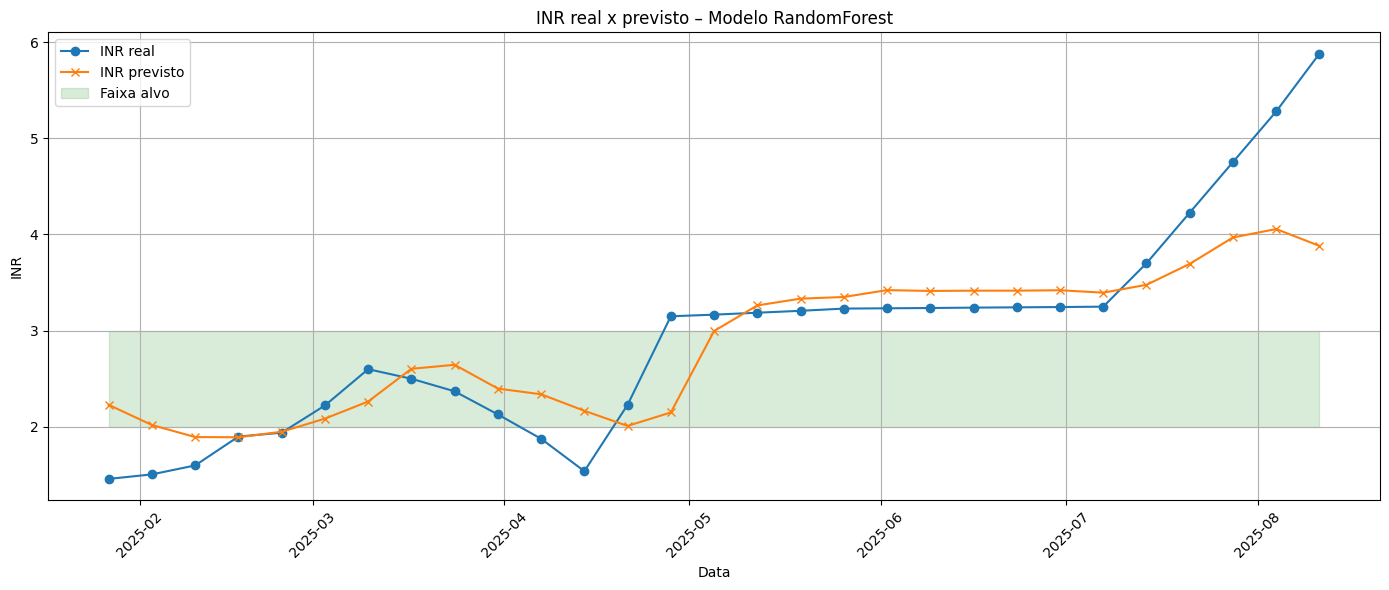

In [125]:
plot_inr_prediction(dates_test, y_test.values, y_pred_test, low_vals, high_vals, title="INR real x previsto – Modelo RandomForest")

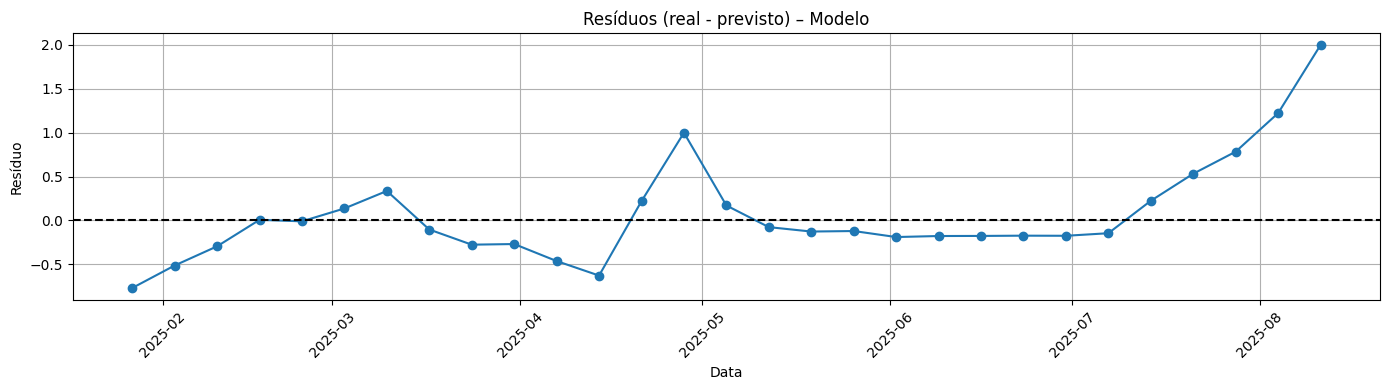

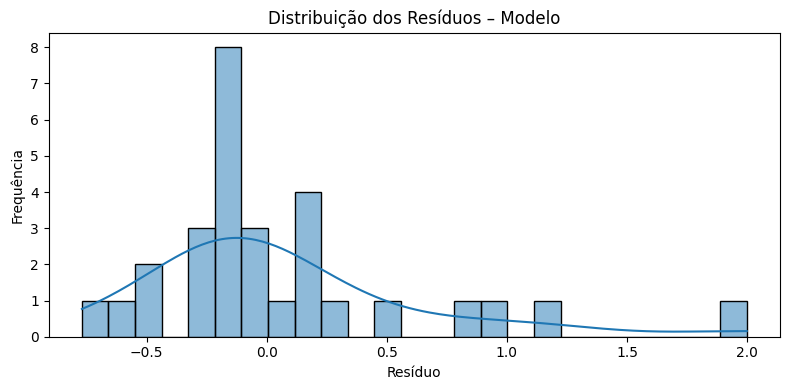

In [126]:
plot_residuals(dates_test, y_test.values, y_pred_test)

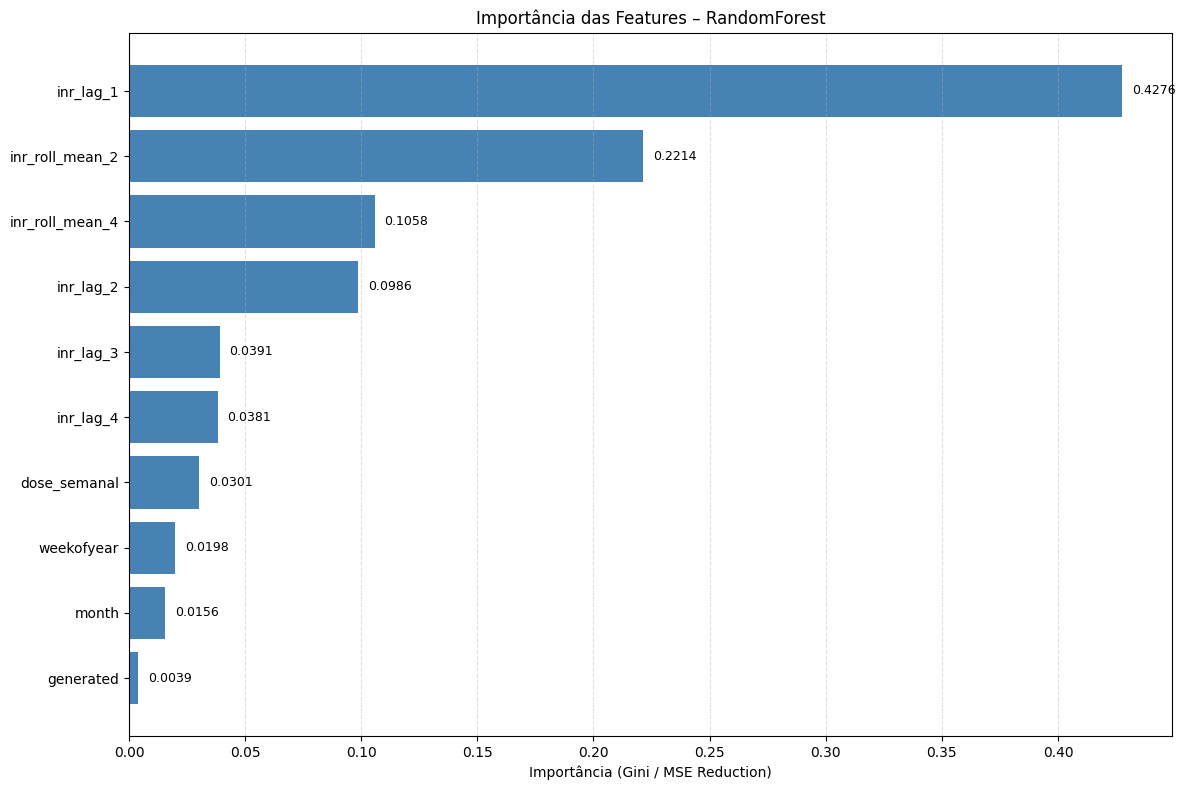

In [127]:
plot_rf_feature_importance(model_rf, feature_names=fc1, top_n=15)

## 5. Resultados da análise

In [128]:
def pct_within_range(y_pred, low, high):
    """
    Percentual de predições dentro da faixa [low, high].
    low/high podem ser escalares ou arrays com mesmo comprimento de y_pred.
    Retorna valor em percent (0-100).
    """
    y_pred = np.asarray(y_pred)
    low_arr = np.asarray(low)
    high_arr = np.asarray(high)
    
    if low_arr.shape != y_pred.shape or high_arr.shape != y_pred.shape:
        low_arr = np.full_like(y_pred, low)
        high_arr = np.full_like(y_pred, high)

    within = ((y_pred >= low_arr) & (y_pred <= high_arr)).sum()
    return float(within) / float(len(y_pred)) * 100.0

def avg_distance_to_range(y_pred, low, high):
    """
    Distância média até a faixa [low, high]. Dentro da faixa => 0.
    low/high podem ser escalares ou arrays.
    Retorna float (mesma unidade de y_pred).
    """
    y_pred = np.asarray(y_pred)
    low_arr = np.asarray(low)
    high_arr = np.asarray(high)
    
    if low_arr.shape != y_pred.shape or high_arr.shape != y_pred.shape:
        low_arr = np.full_like(y_pred, low)
        high_arr = np.full_like(y_pred, high)

    dist = np.where(y_pred < low_arr, low_arr - y_pred,
                    np.where(y_pred > high_arr, y_pred - high_arr, 0.0))
    return float(np.mean(dist))

def evaluate_models(models: dict, X_test, y_test, low, high, return_preds=False):
    """
    Avalia múltiplos modelos de regressão em X_test/y_test.
    - models: dict {name: model_object} (modelo deve ter .predict(X))
    - X_test, y_test: arrays ou DataFrame/Series
    - low, high: escalares ou arrays (mesmo tamanho de y_test) com limites alvo
    - return_preds: se True, retorna também dict com predições por modelo
    Retorna: results_df (DataFrame com métricas por modelo), preds_dict (opcional)
    Métricas calculadas: MAE, RMSE, pct_within_range(%), avg_distance_to_range
    """
    results = []
    preds = {}
    X_arr = X_test  # assume compatível com .predict do modelo
    y_arr = np.asarray(y_test)

    for name, model in models.items():
        try:
            y_pred = model.predict(X_arr)
        except Exception as e:
            # tentar converter X_arr para numpy se for DataFrame (algumas APIs exigem)
            try:
                y_pred = model.predict(np.asarray(X_arr))
            except Exception as e2:
                raise RuntimeError(f"Falha ao prever com modelo '{name}': {e}; fallback: {e2}")

        # armazenar predições
        preds[name] = np.asarray(y_pred)

        # métricas clássicas
        # filtrar pares válidos (em caso de NaNs nas previsões)
        mask_valid = ~np.isnan(preds[name])
        if mask_valid.sum() == 0:
            mae = np.nan
            rmse = np.nan
        else:
            # alinhar ground truth (assume que y_test tamanho = preds)
            y_valid = y_arr[mask_valid]
            ypred_valid = preds[name][mask_valid]
            mae = mean_absolute_error(y_valid, ypred_valid)
            rmse = mean_squared_error(y_valid, ypred_valid)

        # métricas da faixa alvo (aceita low/high escalares ou arrays)
        pct_range = pct_within_range(preds[name], low, high)
        avg_dist = avg_distance_to_range(preds[name], low, high)

        results.append({
            "model": name,
            "MAE": mae,
            "RMSE": rmse,
            "%_within_range": pct_range,
            "avg_distance_to_range": avg_dist,
            "n_test": len(y_arr)})

    results_df = pd.DataFrame(results).set_index("model")
    if return_preds:
        return results_df, preds
    return results_df


In [137]:
models = {
     "xgb": model_xgb,
     "lgb": model_lgb,
     "rf": model_rf
 }
results_df, preds = evaluate_models(models, X_test, y_test, low_vals, high_vals, return_preds=True)
display(results_df)

,MAE,RMSE,%_within_range,avg_distance_to_range,n_test
model,,,,,
xgb,0.369518,0.287914,31.034483,0.293523,29
lgb,0.420583,0.362046,48.275862,0.320924,29
rf,0.390111,0.329949,41.379310,0.268011,29


#### Recomendações, em desenvolvimento

In [ ]:
def build_next_week_features(last_row, feature_cols, date_col='test_date', target_col='inr', freq_days=7):
    """
    Constrói um DataFrame (1 linha) com as features necessárias para predizer a próxima semana,
    a partir da última observação (last_row: pd.Series).
    - last_row: pd.Series (última linha observada, com colunas usadas nas features)
    - feature_cols: lista das colunas de entrada que o modelo espera (por ex. ['dose_semanal','inr_lag_1',...])
    - retorna: pd.DataFrame com 1 linha, colunas = feature_cols
    -----------------------------------------
    Observações/assunções:
    - Lags: inr_lag_1 será o inr atual (last_row['inr']), inr_lag_2 será last_row['inr_lag_1'], etc.
      Se alguma lag não existir em last_row (por exemplo você usou menos lags), preenche com NaN -> 0.
    - Rolling: inr_roll_mean_w usa last_row's rolling e o incorpora sem recomputar usando histórico longo.
      Aqui assumimos rolling já presente em last_row como última média deslocada (como no pipeline anterior),
      então copiamos o valor existente. Se não existir, deixa NaN -> preencher depois.
    - Se precisar recalcular rolling usando histórico, passe o DataFrame inteiro e eu dou outra função.
    """
    # garantir série
    if not isinstance(last_row, pd.Series):
        raise ValueError("last_row deve ser uma pd.Series (última linha do dataset do paciente).")
    
    # construir uma linha vazia
    next_dict = {}
    
    # regra: para cada feature:
    for f in feature_cols:
        if f == 'dose_semanal':
            # manter mesma dose atual por default (ajuste só após recomendação)
            next_dict[f] = last_row.get('dose_semanal', np.nan)
            continue
        if f.startswith('inr_lag_'):
            # extrair número do lag
            try:
                lag = int(f.split('_')[-1])
            except:
                lag = None
            if lag is None:
                next_dict[f] = last_row.get(f, np.nan)
                continue
            # inr_lag_1 (próximo passo) deve ser o inr atual
            if lag == 1:
                next_dict[f] = last_row.get('inr', last_row.get('inr_lag_1', np.nan))
            else:
                # inr_lag_2_next = last_row['inr_lag_1'], inr_lag_3_next = last_row['inr_lag_2'], etc.
                prev_name = f'inr_lag_{lag-1}'
                next_dict[f] = last_row.get(prev_name, np.nan)
            continue
        if f.startswith('inr_roll_mean_'):
            # assumimos que a média rolante já foi calculada e está deslocada (shifted) no last_row
            # então copiamos o valor atual (que foi calculado com dados até last_row)
            next_dict[f] = last_row.get(f, np.nan)
            continue
        if f == 'inr_diff':
            # inr_diff para o "próximo" previsto não é conhecido; podemos usar last diff
            next_dict[f] = last_row.get('inr_diff', np.nan)
            continue
        if f == 'generated_flag' or f == 'generated':
            # o próximo ponto ainda não é gerado; marcar 1 se quisermos indicar que é uma previsão (0 default)
            next_dict[f] = 0
            continue
        # features temporais (week/month/day) podem ser inferidas incrementando a data
        if f in ['weekofyear', 'month', 'year', 'dayofweek']:
            # data do próximo ponto:
            last_date = pd.to_datetime(last_row.get(date_col))
            next_date = last_date + pd.Timedelta(days=int(freq_days))
            if f == 'weekofyear':
                next_dict[f] = int(next_date.isocalendar().week)
            elif f == 'month':
                next_dict[f] = int(next_date.month)
            elif f == 'year':
                next_dict[f] = int(next_date.year)
            elif f == 'dayofweek':
                next_dict[f] = int(next_date.weekday())
            continue
        # fallback: se a coluna existe em last_row, copie; senão NaN
        next_dict[f] = last_row.get(f, np.nan)
    
    X_next = pd.DataFrame([next_dict], columns=feature_cols)
    # preencher NaNs razoavelmente (ffill/backfill conforme disponibilidade)
    X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
    return X_next


def recommend_dose_from_prediction(model, X_next, last_dose, low, high,
                                   pct_small=0.10, pct_large=0.15,
                                   warn_threshold=1.0):
    """
    Recebe:
      - model: modelo treinado (ex: XGBRegressor)
      - X_next: pd.DataFrame (1 linha) com features da próxima semana
      - last_dose: último dose_semanal registrado (float)
      - low, high: limites alvo (float)
      - pct_small: 0.10 => 10% (ajuste quando pred diff <= 0.5)
      - pct_large: 0.15 => 15% (ajuste quando pred diff <= 1.0)
      - warn_threshold: se diferença > warn_threshold, sinaliza avaliação clínica
    
    Retorna dicionário com:
      - prediction: valor previsto do INR
      - decision: 'increase'/'decrease'/'none'
      - recommended_pct: percentual (positivo para aumento, negativo para redução)
      - recommended_dose: novo valor da dose_semanal sugerida
      - reason: texto explicativo
      - alert: True/False se diferença > warn_threshold (aconselhar consulta médica)
    """
    if X_next.shape[0] != 1:
        raise ValueError("X_next deve ter exatamente 1 linha.")
    # previsão
    pred = float(model.predict(X_next)[0])
    
    # inicial padrão: sem mudança
    decision = 'none'
    recommended_pct = 0.0
    recommended_dose = float(last_dose)
    alert = False
    reason = "Predição dentro da faixa alvo — sem ajuste recomendado."

    # se dentro da faixa:
    if low <= pred <= high:
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }
    
    # se abaixo do mínimo
    if pred < low:
        diff = low - pred
        # tiny deviation: up to 0.5 -> +pct_small
        if diff <= 0.5:
            recommended_pct = pct_small
            decision = 'increase'
            reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Recomenda-se aumento conservador de {pct_small*100:.0f}% na dose semanal."
        elif diff <= 1.0:
            recommended_pct = pct_large
            decision = 'increase'
            reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Recomenda-se aumento de {pct_large*100:.0f}% na dose semanal."
        else:
            # muito abaixo -> alertar
            recommended_pct = pct_large
            decision = 'increase'
            alert = True
            reason = (f"Predito {diff:.3f} abaixo do limite inferior ({low}). Diferença grande (> {warn_threshold}). "
                      f"Recomenda-se avaliação clínica; sugestão inicial: aumento de {pct_large*100:.0f}% para verificação.")
        # calcular nova dose
        recommended_dose = float(last_dose) * (1.0 + recommended_pct)
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }
    
    # se acima do máximo
    if pred > high:
        diff = pred - high
        if diff <= 0.5:
            recommended_pct = -pct_small
            decision = 'decrease'
            reason = f"Predito {diff:.3f} acima do limite superior ({high}). Recomenda-se redução conservadora de {pct_small*100:.0f}% na dose semanal."
        elif diff <= 1.0:
            recommended_pct = -pct_large
            decision = 'decrease'
            reason = f"Predito {diff:.3f} acima do limite superior ({high}). Recomenda-se redução de {pct_large*100:.0f}% na dose semanal."
        else:
            recommended_pct = -pct_large
            decision = 'decrease'
            alert = True
            reason = (f"Predito {diff:.3f} acima do limite superior ({high}). Diferença grande (> {warn_threshold}). "
                      f"Recomenda-se avaliação clínica; sugestão inicial: redução de {pct_large*100:.0f}% para verificação.")
        recommended_dose = float(last_dose) * (1.0 + recommended_pct)
        return {
            "prediction": pred,
            "decision": decision,
            "recommended_pct": recommended_pct,
            "recommended_dose": recommended_dose,
            "reason": reason,
            "alert": alert
        }

In [ ]:
# supondo que você tem:
# - model (XGBoost treinado)
# - feature_cols (lista de features que o modelo usa, na ordem correta)
# - df_features (DataFrame com as features geradas por create_time_features, ordenado por date asc)

# pegar última linha observada do paciente
last_row = df1.iloc[-1]   # pd.Series

# construir features da próxima semana
X_next = build_next_week_features(last_row, feature_cols=fc1, date_col=DATE_COL, target_col=TARGET_COL)

# chamar recomendador
last_dose = float(last_row['dose_semanal'])
low = float(last_row['low_range'])
high = float(last_row['high_range'])

recommendation = recommend_dose_from_prediction(model, X_next, last_dose, low, high,
                                                pct_small=0.10, pct_large=0.15, warn_threshold=1.0)

# mostrar resultado
print("Previsão INR próxima semana:", recommendation['prediction'])
print("Decisão:", recommendation['decision'])
print("Recomendação (%):", f"{recommendation['recommended_pct']*100:.1f}%")
print("Dose semanal atual:", last_dose)
print("Dose semanal sugerida:", round(recommendation['recommended_dose'], 2))
print("Alerta clínico:", recommendation['alert'])
print("Explicação:", recommendation['reason'])

#### Recomendações 2.0

In [ ]:
# ========== Função auxiliar: atualiza lags e rolling a partir de histórico ==========
def _update_lags_and_rolls(feature_cols, history_inr, roll_windows):
    """
    Dado history_inr (lista, último item = inr mais recente observado/predito),
    retorna um dict com chaves 'inr_lag_k' e 'inr_roll_mean_w' preenchidas
    de acordo com feature_cols presentes.
    """
    d = {}
    # identificar lags solicitados nas feature_cols
    lag_cols = [c for c in feature_cols if c.startswith('inr_lag_')]
    # ordenar por lag crescente (inr_lag_1, inr_lag_2, ...)
    lag_nums = sorted([int(c.split('_')[-1]) for c in lag_cols]) if lag_cols else []
    # preencher lags: inr_lag_1 = history_inr[-1], inr_lag_2 = history_inr[-2], ...
    for k in lag_nums:
        idx = -k  # -1 => último, -2 => penúltimo
        if len(history_inr) >= k:
            d[f'inr_lag_{k}'] = float(history_inr[idx])
        else:
            # se não houver histórico suficiente, preencher com NaN (ou 0)
            d[f'inr_lag_{k}'] = float(np.nan)

    # rolling means: inr_roll_mean_w = média dos últimos w valores (sem incluir o valor futuro)
    for w in roll_windows:
        if len(history_inr) >= 1:
            # média dos últimos w valores (ou de todos se menos que w)
            vals = history_inr[-w:] if len(history_inr) >= w else history_inr[:]
            d[f'inr_roll_mean_{w}'] = float(np.mean(vals)) if len(vals) > 0 else float(np.nan)
        else:
            d[f'inr_roll_mean_{w}'] = float(np.nan)

    return d

# ========== Função para construir vetor de features para o próximo passo ==========
def build_feature_vector_next_step(last_date, last_history_inr, last_row, feature_cols,
                                   date_col='test_date', freq_days=7, roll_windows=None):
    """
    Constrói um DataFrame (1 linha) contendo as features que o modelo espera para
    a próxima semana (ou próximo passo com freq_days).
    - last_date: ultima data observada (pd.Timestamp)
    - last_history_inr: lista de floats com histórico de INR (ordem cronológica, último = mais recente)
    - last_row: pd.Series contendo colunas auxiliares (dose_semanal, inr_diff, low_range, high_range, generated, etc.)
    - feature_cols: lista de features que o modelo espera (nomes)
    - roll_windows: lista de janelas rolling já usadas no pipeline (ex: [3,4])
    """
    if roll_windows is None:
        # extrair roll windows que podem existir no feature_cols
        roll_windows = []
        for c in feature_cols:
            if c.startswith('inr_roll_mean_'):
                try:
                    roll_windows.append(int(c.split('_')[-1]))
                except:
                    pass
        roll_windows = sorted(set(roll_windows))

    next_date = pd.to_datetime(last_date) + pd.Timedelta(days=int(freq_days))
    vec = {}

    # preencher features temporais
    if 'weekofyear' in feature_cols:
        vec['weekofyear'] = int(next_date.isocalendar().week)
    if 'month' in feature_cols:
        vec['month'] = int(next_date.month)
    if 'year' in feature_cols:
        vec['year'] = int(next_date.year)
    if 'dayofweek' in feature_cols:
        vec['dayofweek'] = int(next_date.weekday())

    # dose_semanal: por default pegar a última registrada (ajuste será sugerido depois)
    if 'dose_semanal' in feature_cols:
        vec['dose_semanal'] = float(last_row.get('dose_semanal', np.nan))

    # inr_diff: usar último inr_diff (poderia ser estimado, mas mantemos último)
    if 'inr_diff' in feature_cols:
        vec['inr_diff'] = float(last_row.get('inr_diff', 0.0))

    # generated flag: futuro ainda não gerado -> 0
    if 'generated_flag' in feature_cols or 'generated' in feature_cols:
        # detectar qual nome está na lista e preencher
        if 'generated_flag' in feature_cols:
            vec['generated_flag'] = int(0)
        if 'generated' in feature_cols:
            vec['generated'] = int(0)

    # low_range, high_range (copiar do last_row)
    if 'low_range' in feature_cols:
        vec['low_range'] = float(last_row.get('low_range', np.nan))
    if 'high_range' in feature_cols:
        vec['high_range'] = float(last_row.get('high_range', np.nan))

    # atualizar lags e rolling via histórico (history inclui valores reais + previsões já geradas)
    lag_and_roll = _update_lags_and_rolls(feature_cols, last_history_inr, roll_windows)
    vec.update(lag_and_roll)

    # preencher quaisquer outras features que possam simplesmente ser copiadas do last_row
    for f in feature_cols:
        if f in vec:
            continue
        if f in last_row.index:
            vec[f] = last_row.get(f)
        else:
            # valor padrão
            vec[f] = float(np.nan)

    # manter apenas as colunas na ordem feature_cols
    row = {c: vec.get(c, np.nan) for c in feature_cols}
    X_next = pd.DataFrame([row], columns=feature_cols)
    # preencher NaNs com estratégia conservadora: forward/backfill com zeros em último caso
    X_next = X_next.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).fillna(0)
    return X_next, next_date

# ========== Função principal: previsão multi-step + recomendações ==========
def multi_step_forecast_and_recommend(model, df_features, feature_cols,
                                      horizon=4, freq_days=7,
                                      pct_small=0.10, pct_large=0.15, warn_threshold=1.0,
                                      max_pct_change=0.20):
    """
    Gera previsões multi-step e recomendações de dose para cada passo.
    - model: modelo treinado (XGBRegressor)
    - df_features: DataFrame com histórico (ordenado por data asc), deve conter a última linha observada
    - feature_cols: lista de features que o modelo espera
    - horizon: número de passos (semanas) à frente para prever
    - pct_small / pct_large / warn_threshold / max_pct_change: regras de ajuste
    Retorna DataFrame com colunas:
      ['step','date','prediction','last_dose','recommended_pct','recommended_dose','decision','alert','reason']
    """
    # validações mínimas
    if df_features is None or len(df_features) == 0:
        raise ValueError("df_features vazio.")
    df = df_features.copy().reset_index(drop=True)
    last_row = df.iloc[-1]
    last_date = pd.to_datetime(last_row['test_date'])
    # construir histórico de INR (lista), último = mais recente
    # tomar um histórico razoável (por ex. últimos 12 valores) para calcular rolls; aqui usamos todo o histórico disponível
    history_inr = df['inr'].dropna().astype(float).tolist()
    # assegurar que history_inr[-1] é o valor mais recente (deveria ser)
    if len(history_inr) == 0:
        raise ValueError("Sem histórico de INR válido para construir previsões.")

    # descobrir roll windows que existem entre feature_cols
    roll_windows = sorted({int(c.split('_')[-1]) for c in feature_cols if c.startswith('inr_roll_mean_')})

    rows_out = []
    current_history = history_inr[:]  # copia mutável
    current_last_row = last_row.copy()

    # iterative multi-step
    for step in range(1, horizon + 1):
        # construir features para próximo passo
        X_next, next_date = build_feature_vector_next_step(
            last_date=current_last_row['test_date'] if 'test_date' in current_last_row.index else last_date,
            last_history_inr=current_history,
            last_row=current_last_row,
            feature_cols=feature_cols,
            date_col='test_date',
            freq_days=freq_days,
            roll_windows=roll_windows
        )

        # prever
        pred = float(model.predict(X_next)[0])

        # recomendação baseada na regra
        low = float(current_last_row.get('low_range', np.nan))
        high = float(current_last_row.get('high_range', np.nan))
        # fallback se low/high NaN: usar defaults (opcional)
        if np.isnan(low):
            low = 2.5
        if np.isnan(high):
            high = 3.5

        # cálculo decisão
        decision = 'none'
        recommended_pct = 0.0
        recommended_dose = float(current_last_row.get('dose_semanal', np.nan))
        alert = False
        reason = "Dentro da faixa alvo."

        if low <= pred <= high:
            decision = 'none'
            recommended_pct = 0.0
            recommended_dose = float(current_last_row.get('dose_semanal', np.nan))
            reason = "Previsão dentro da faixa alvo. Sem ajuste."
        elif pred < low:
            diff = low - pred
            if diff <= 0.5:
                recommended_pct = pct_small
                decision = 'increase'
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Aumentar {pct_small*100:.0f}%."
            elif diff <= 1.0:
                recommended_pct = pct_large
                decision = 'increase'
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Aumentar {pct_large*100:.0f}%."
            else:
                recommended_pct = pct_large
                decision = 'increase'
                alert = True
                reason = f"Predito {diff:.3f} abaixo do limite inferior ({low}). Diferença grande; avaliar clinicamente. Sugestão: +{pct_large*100:.0f}%."
        else:  # pred > high
            diff = pred - high
            if diff <= 0.5:
                recommended_pct = -pct_small
                decision = 'decrease'
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Reduzir {pct_small*100:.0f}%."
            elif diff <= 1.0:
                recommended_pct = -pct_large
                decision = 'decrease'
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Reduzir {pct_large*100:.0f}%."
            else:
                recommended_pct = -pct_large
                decision = 'decrease'
                alert = True
                reason = f"Predito {diff:.3f} acima do limite superior ({high}). Diferença grande; avaliar clinicamente. Sugestão: -{pct_large*100:.0f}%."

        # aplicar clip de segurança (ex: não mais que max_pct_change em magnitude)
        if recommended_pct != 0.0:
            if recommended_pct > 0:
                recommended_pct = min(recommended_pct, max_pct_change)
            else:
                recommended_pct = max(recommended_pct, -max_pct_change)

        last_dose = float(current_last_row.get('dose_semanal', np.nan))
        if np.isnan(last_dose):
            # fallback
            last_dose = 100.0

        recommended_dose = float(last_dose * (1.0 + recommended_pct))

        # armazenar saída do passo
        rows_out.append({
            'step': step,
            'date': pd.to_datetime(next_date),
            'prediction': pred,
            'last_dose': last_dose,
            'recommended_pct': recommended_pct,
            'recommended_dose': recommended_dose,
            'decision': decision,
            'alert': alert,
            'reason': reason,
            'low': low,
            'high': high
        })

        # atualizar histórico e last_row para o próximo passo (autorregressivo)
        current_history.append(pred)   # usar a previsão como novo ponto na história
        # atualizar current_last_row: copy e ajustar valores que mudam para o próximo passo
        # - test_date passa a next_date
        # - dose_semanal: assumir que a dose NÃO foi aplicada automaticamente; mantemos last_dose here.
        #   Se você quiser simular aplicação da recomendação, substitua com recommended_dose.
        current_last_row = current_last_row.copy()
        current_last_row['test_date'] = pd.to_datetime(next_date)
        # manter dose_semanal como última observada para a construção de features; não aplicamos a recomendação automaticamente
        # se quiser simular a aplicação, substitua a linha acima por:
        # current_last_row['dose_semanal'] = recommended_dose
        # atualiza inr (último valor) para permitir construção de lags subsequentemente
        current_last_row['inr'] = pred
        # atualiza inr_diff como pred - anterior real
        prev_inr = current_history[-2] if len(current_history) >= 2 else pred
        current_last_row['inr_diff'] = pred - prev_inr

    # retornar tabela
    out_df = pd.DataFrame(rows_out)
    return out_df

In [ ]:
# ========== Exemplo de uso ==========
# - model: seu XGBoost treinado
# - df_features: DataFrame com histórico, ordenado por date asc, e com colunas usadas no feature_cols
# - feature_cols: lista de features que o modelo espera

# Exemplo:
df_features = df1  # já existente
feature_cols = fc1  # ou a lista que você usou para treinar

# fazer previsão multi-step (ex.: 4 semanas)
out = multi_step_forecast_and_recommend(model, df_features, feature_cols, horizon=4)
display(out)